good definition of |g|

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import galsim
import scipy.stats as stats
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import scipy

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [3]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, utils, plot, generator, results_processing, boxplot

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_alpha, denorm, delta_min, norm, load_vae_full
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, plot_rgb, createCircularMask, mean_var, plot_corner_latent, scatter_galaxies
from tools_for_VAE.results_processing import deblender_processing
from tools_for_VAE.boxplot import boxplot


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Function to import deblender

In [4]:
deblender_lsst,deblender_utils_lsst, encoder_lsst, decoder_lsst, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v8/bis_bis/mse/', #7/bis
                                                                                     6, folder = True)#6/train_6  #7 (PReLu pas sur echantillons 28)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
deblender_lsst_euclid,deblender_utils_lsst_euclid, encoder_lsst_euclid, decoder_lsst_euclid, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST_EUCLID/deblender/v8/bis/mse/',#6/bis_bis
                                                                                            10, folder = True)#5/train_7  #6 (PReLu pas sur echantillons 28)

# Fix parameters

In [6]:
# Batch size for training
batch_size = 100

# Physical stamp size
phys_stamp_size_euclid = 6.4 # arcsec for VIS Euclid instrument
phys_stamp_size_lsst = 3.2 # arcsec for LSST instrument

# Pixel scales
pixel_scale_euclid_vis = 0.1 # arcsec/pixel
pixel_scale_lsst = 0.2

# Stamp size used
stamp_size = int(phys_stamp_size_euclid/pixel_scale_euclid_vis)

# Load test data

Load shifts and images

In [7]:
data_dir = '/sps/lsst/users/barcelin/data/blended_images/28/test/'
root = 'galaxies_blended_20191024'

In [8]:
shifts = np.load(os.path.join(data_dir, root+'_0_shifts.npy'))

In [9]:
images = np.load(data_dir+'galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')
test_sample = [data_dir+'galaxies_blended_20191024_0_images.npy']

Load rest of test data

In [10]:
dfs = []

#dfs.append(pd.read_csv(os.path.join(data_dir, root+'_010_data.csv')))
dfs.append(pd.read_csv(os.path.join(data_dir, root+'_0_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
nb_blended_gal                10000 non-null int64
SNR                           10000 non-null float64
SNR_peak                      10000 non-null float64
redshift                      10000 non-null float64
moment_sigma                  10000 non-null float64
e1                            10000 non-null float64
e2                            10000 non-null float64
mag                           10000 non-null float64
mag_ir                        10000 non-null float64
closest_x                     10000 non-null float64
closest_y                     10000 non-null float64
closest_redshift              10000 non-null float64
closest_moment_sigma          10000 non-null float64
closest_e1                    10000 non-null float64
closest_e2                    10000 non-null float64
closest_mag                   10000 non-null float64
closest_mag_ir                10000 non-null f

In [12]:
df.describe()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,closest_moment_sigma,closest_e1,closest_e2,closest_mag,closest_mag_ir,blendedness_total_lsst,blendedness_aperture_lsst,blendedness_total_euclid,blendedness_closest_lsst,blendedness_closest_euclid
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,6927.000000,6927.000000,6927.000000,6927.000000,6927.000000
mean,2.326800,120.542613,0.184105,0.923295,2.175666,0.003445,-0.001777,25.974744,-1.951157,-0.002958,...,1.953143,-0.004213,-0.005069,26.998331,-1.251281,0.225986,0.359323,0.155983,0.539313,0.269388
std,1.111002,237.650885,0.428907,0.733529,0.533526,0.278100,0.278661,1.404586,1.374391,0.404644,...,0.371246,0.292470,0.297245,0.929195,1.240879,0.145028,0.179466,0.160187,0.232039,0.234183
min,1.000000,6.343976,0.006464,0.006500,1.488476,-1.564115,-1.397318,20.037094,-7.306114,-0.999368,...,1.492670,-1.576889,-1.358944,20.448996,-6.996996,0.001561,0.001576,0.000145,0.023587,0.000245
25%,1.000000,25.346898,0.038478,0.405900,1.804618,-0.156923,-0.157973,25.240076,-2.837569,-0.202946,...,1.697775,-0.188777,-0.191581,26.671884,-1.904178,0.104868,0.221880,0.033467,0.345620,0.072935
50%,2.000000,45.650881,0.067025,0.718750,2.042732,0.001054,0.002363,26.283262,-1.765570,0.000000,...,1.852790,-0.004441,-0.005185,27.251823,-1.030067,0.205507,0.379510,0.100183,0.542005,0.197978
75%,3.000000,97.979607,0.141105,1.139800,2.394902,0.160726,0.157897,27.013120,-0.958320,0.196136,...,2.093602,0.173691,0.181968,27.630291,-0.371419,0.327835,0.495176,0.228232,0.729688,0.418673
max,4.000000,3050.680684,7.746850,5.208000,5.651824,1.465109,1.434683,27.996072,0.946252,0.999947,...,5.232187,1.991984,1.614200,27.999770,0.946252,0.764361,0.763329,0.916789,0.997504,0.988586


27.996071897478828

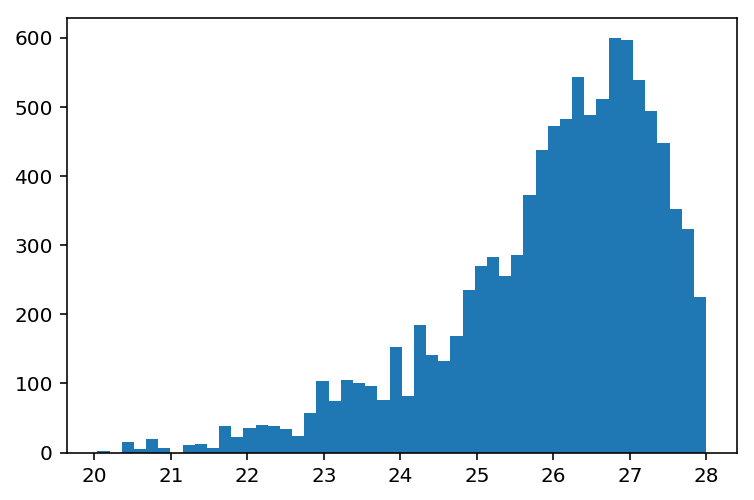

In [12]:
_ = plt.hist(df['mag'], bins = 50)
np.max(df['mag'])

# Parameters

In [13]:
bands_lsst = [4,5,6,7,8,9]
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

psf = galsim.Kolmogorov(fwhm=0.65)
pix_scale_lsst = 0.2

batch_size = 100

# LSST only

## Shape reproduction

In [122]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [113]:
ellipticities_lsst,flux_in_lsst, flux_out_lsst

(array([[[ 0.22338237,  0.65504217],
         [ 0.19122709,  0.47694859]],
 
        [[ 0.10585869, -0.37887833],
         [ 0.20504175, -0.48171526]],
 
        [[-0.01401994, -0.02305583],
         [-0.05775093, -0.27395874]],
 
        ...,
 
        [[-0.08235295, -0.08641091],
         [-0.00982921, -0.01246735]],
 
        [[ 0.01248616,  0.07185503],
         [ 0.01989135,  0.10399537]],
 
        [[-0.23665333,  0.23031981],
         [-0.26211151,  0.25745428]]]),
 array([ 22413.87032542,  27835.62335838,  42708.63674648, ...,
         64812.9848983 , 115141.56265215,  77899.24031098]),
 array([ 21441.125,  27673.715,  41745.04 , ...,  52570.65 , 116298.14 ,
         80857.766], dtype=float32))

In [14]:
df = results_processing.deblender_processing(deblender_lsst,
                                             data_dir,                                           
                                             root,
                                             test_sample[0],
                                             bands_lsst,
                                             2,
                                             stamp_size, 
                                             batch_size,
                                             psf,
                                             pix_scale_lsst)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99

(10000, 2, 2)


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
nb_blended_gal                10000 non-null int64
SNR                           10000 non-null float64
SNR_peak                      10000 non-null float64
redshift                      10000 non-null float64
moment_sigma                  10000 non-null float64
e1                            10000 non-null float64
e2                            10000 non-null float64
mag                           10000 non-null float64
mag_ir                        10000 non-null float64
closest_x                     10000 non-null float64
closest_y                     10000 non-null float64
closest_redshift              10000 non-null float64
closest_moment_sigma          10000 non-null float64
closest_e1                    10000 non-null float64
closest_e2                    10000 non-null float64
closest_mag                   10000 non-null float64
closest_mag_ir                10000 non-null f

In [126]:
df.describe()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,blendedness_closest_lsst,blendedness_closest_euclid,e1_in,e1_out,e2_in,e2_out,e_in,e_out,mag_in,mag_out
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,6927.000000,6927.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.326800,120.542613,0.184105,0.923295,2.175666,0.003445,-0.001777,25.974744,-1.951157,-0.002958,...,0.539313,0.269388,0.003445,0.001631,-0.001777,-0.006408,0.329521,0.302307,25.975286,25.985426
std,1.111002,237.650885,0.428907,0.733529,0.533526,0.278100,0.278661,1.404586,1.374391,0.404644,...,0.232039,0.234183,0.278100,0.258402,0.278661,0.262197,0.215433,0.210152,1.401905,1.395050
min,1.000000,6.343976,0.006464,0.006500,1.488476,-1.564115,-1.397318,20.037094,-7.306114,-0.999368,...,0.023587,0.000245,-1.564115,-2.538030,-1.397318,-4.932887,0.004438,0.001718,20.098586,20.314331
25%,1.000000,25.346898,0.038478,0.405900,1.804618,-0.156923,-0.157973,25.240076,-2.837569,-0.202946,...,0.345620,0.072935,-0.156923,-0.143555,-0.157973,-0.145506,0.160446,0.147849,25.238726,25.262057
50%,2.000000,45.650881,0.067025,0.718750,2.042732,0.001054,0.002363,26.283262,-1.765570,0.000000,...,0.542005,0.197978,0.001054,-0.000934,0.002363,-0.002883,0.288477,0.259882,26.283154,26.290369
75%,3.000000,97.979607,0.141105,1.139800,2.394902,0.160726,0.157897,27.013120,-0.958320,0.196136,...,0.729688,0.418673,0.160726,0.146028,0.157897,0.137615,0.459258,0.411675,27.012086,27.014606
max,4.000000,3050.680684,7.746850,5.208000,5.651824,1.465109,1.434683,27.996072,0.946252,0.999947,...,0.997504,0.988586,1.465109,1.376316,1.434683,2.010638,1.571839,4.980213,28.073968,28.417881


In [117]:
#np.save('data/e1_e2_lsst_deb_7.npy', ellipticities_lsst)
#np.save('data/flux_in_lsst_deb_7.npy', flux_in_lsst)
np.save('data/flux_out_lsst_deb_7.npy', flux_out_lsst)

In [62]:
ellipticities_lsst = np.load('data/e1_e2_lsst_deb_7.npy')
flux_in_lsst = np.load('data/flux_in_lsst_deb_7.npy')
flux_out_lsst = np.load('data/flux_out_lsst_deb_7.npy')

In [63]:
delta_e1_lsst = df['delta_e1']#ellipticities_lsst[:,1,0] - ellipticities_lsst[:,0,0]
delta_e2_lsst = #ellipticities_lsst[:,1,1] - ellipticities_lsst[:,0,1]

e_out_lsst = np.sqrt(ellipticities_lsst[:,1,0]**2+ellipticities_lsst[:,1,1]**2)
e_in_lsst = np.sqrt(ellipticities_lsst[:,0,0]**2+ellipticities_lsst[:,0,1]**2)
delta_e_lsst = e_out_lsst - e_in_lsst

delta_mag_lsst = -2.5*np.log10(flux_out_lsst/flux_in_lsst)

mag_in_lsst = -2.5*np.log10(flux_in_lsst)+38.4147
mag_out_lsst = -2.5*np.log10(flux_out_lsst)+38.4147

Plots

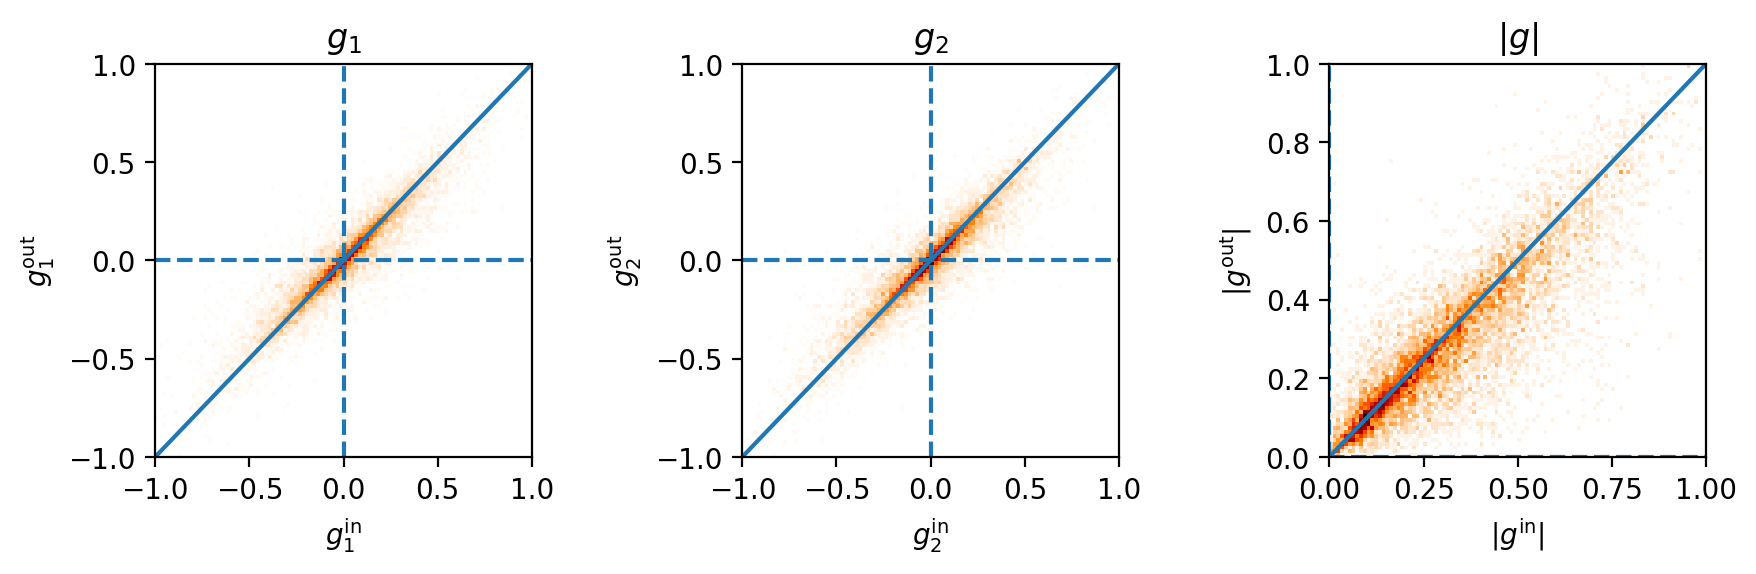

In [64]:
import matplotlib as mpl
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rcdefaults()

fig, axes = plt.subplots(1,3, figsize=(9,3))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_lsst[:,0,i], ellipticities_lsst[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$g_{}$'.format(i+1))#,fontsize=20)# color="w", 
    axes[i].set_xlabel('$g^{{\\rm in}}_{}$'.format(i+1))#,fontsize=20)# color="w", 
    axes[i].set_ylabel('$g^{{\\rm out}}_{}$'.format(i+1))#,fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

emax = 1
_ = axes[2].hist2d(np.sqrt(np.clip(ellipticities_lsst[:,0,0],-1,1)**2+np.clip(ellipticities_lsst[:,0,1],-1,1)**2), np.sqrt(np.clip(ellipticities_lsst[:,1,0],-1,1)**2+np.clip(ellipticities_lsst[:,1,1],-1,1)**2), bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('$|g|$'.format(i+1))#,fontsize=24)# color="w", 
axes[2].tick_params(axis='x')#, colors='w'
axes[2].tick_params(axis='y')#, colors='w'
axes[2].set_xlabel('$|g^{\\rm in}|$')
axes[2].set_ylabel('$|g^{\\rm out}|$')

fig.tight_layout()

In [1]:
import matplotlib as mpl
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rcdefaults()

fig, axes = plt.subplots(1,3, figsize=(9,3))
emax = 1

_ = axes[0].hist2d(df['e1_in'], df['e1_out'], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[0].plot([-emax,+emax],[-emax,+emax])
axes[0].axhline(y=0, ls='--')
axes[0].axvline(x=0, ls='--')
axes[0].set_title('$g_{}$'.format(i+1))#,fontsize=20)# color="w", 
axes[0].set_xlabel('$g^{{\\rm in}}_{}$'.format(i+1))#,fontsize=20)# color="w", 
axes[0].set_ylabel('$g^{{\\rm out}}_{}$'.format(i+1))#,fontsize=20)# color="w", 
axes[0].spines['bottom']#.set_color('w')
axes[0].spines['right']#.set_color('w')
axes[0].spines['left']#.set_color('w')
axes[0].spines['top']#.set_color('w')
axes[0].xaxis.label#.set_color('w')
axes[0].tick_params(axis='x')#, colors='w'
axes[0].tick_params(axis='y')#, colors='w'

_ = axes[1].hist2d(df['e2_in'], df['e2_out'], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[1].plot([-emax,+emax],[-emax,+emax])
axes[1].axhline(y=0, ls='--')
axes[1].axvline(x=0, ls='--')
axes[1].set_title('$g_{}$'.format(i+1))#,fontsize=20)# color="w", 
axes[1].set_xlabel('$g^{{\\rm in}}_{}$'.format(i+1))#,fontsize=20)# color="w", 
axes[1].set_ylabel('$g^{{\\rm out}}_{}$'.format(i+1))#,fontsize=20)# color="w", 
axes[1].spines['bottom']#.set_color('w')
axes[1].spines['right']#.set_color('w')
axes[1].spines['left']#.set_color('w')
axes[1].spines['top']#.set_color('w')
axes[1].xaxis.label#.set_color('w')
axes[1].tick_params(axis='x')#, colors='w'
axes[1].tick_params(axis='y')#, colors='w'

    
emax = 1
_ = axes[2].hist2d(df['e_in'], df['e_out'], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('$|g|$'.format(i+1))#,fontsize=24)# color="w", 
axes[2].tick_params(axis='x')#, colors='w'
axes[2].tick_params(axis='y')#, colors='w'
axes[2].set_xlabel('$|g^{\\rm in}|$')
axes[2].set_ylabel('$|g^{\\rm out}|$')

fig.tight_layout()

NameError: name 'plt' is not defined

In [40]:
# Linear regression
slope_lsst, intercept_lsst, r_value_lsst, p_value_lsst, std_err_lsst = stats.linregress(np.sqrt(ellipticities_lsst[:,0,0]**2+ellipticities_lsst[:,0,1]**2), np.sqrt(ellipticities_lsst[:,1,0]**2+ellipticities_lsst[:,1,1]**2))

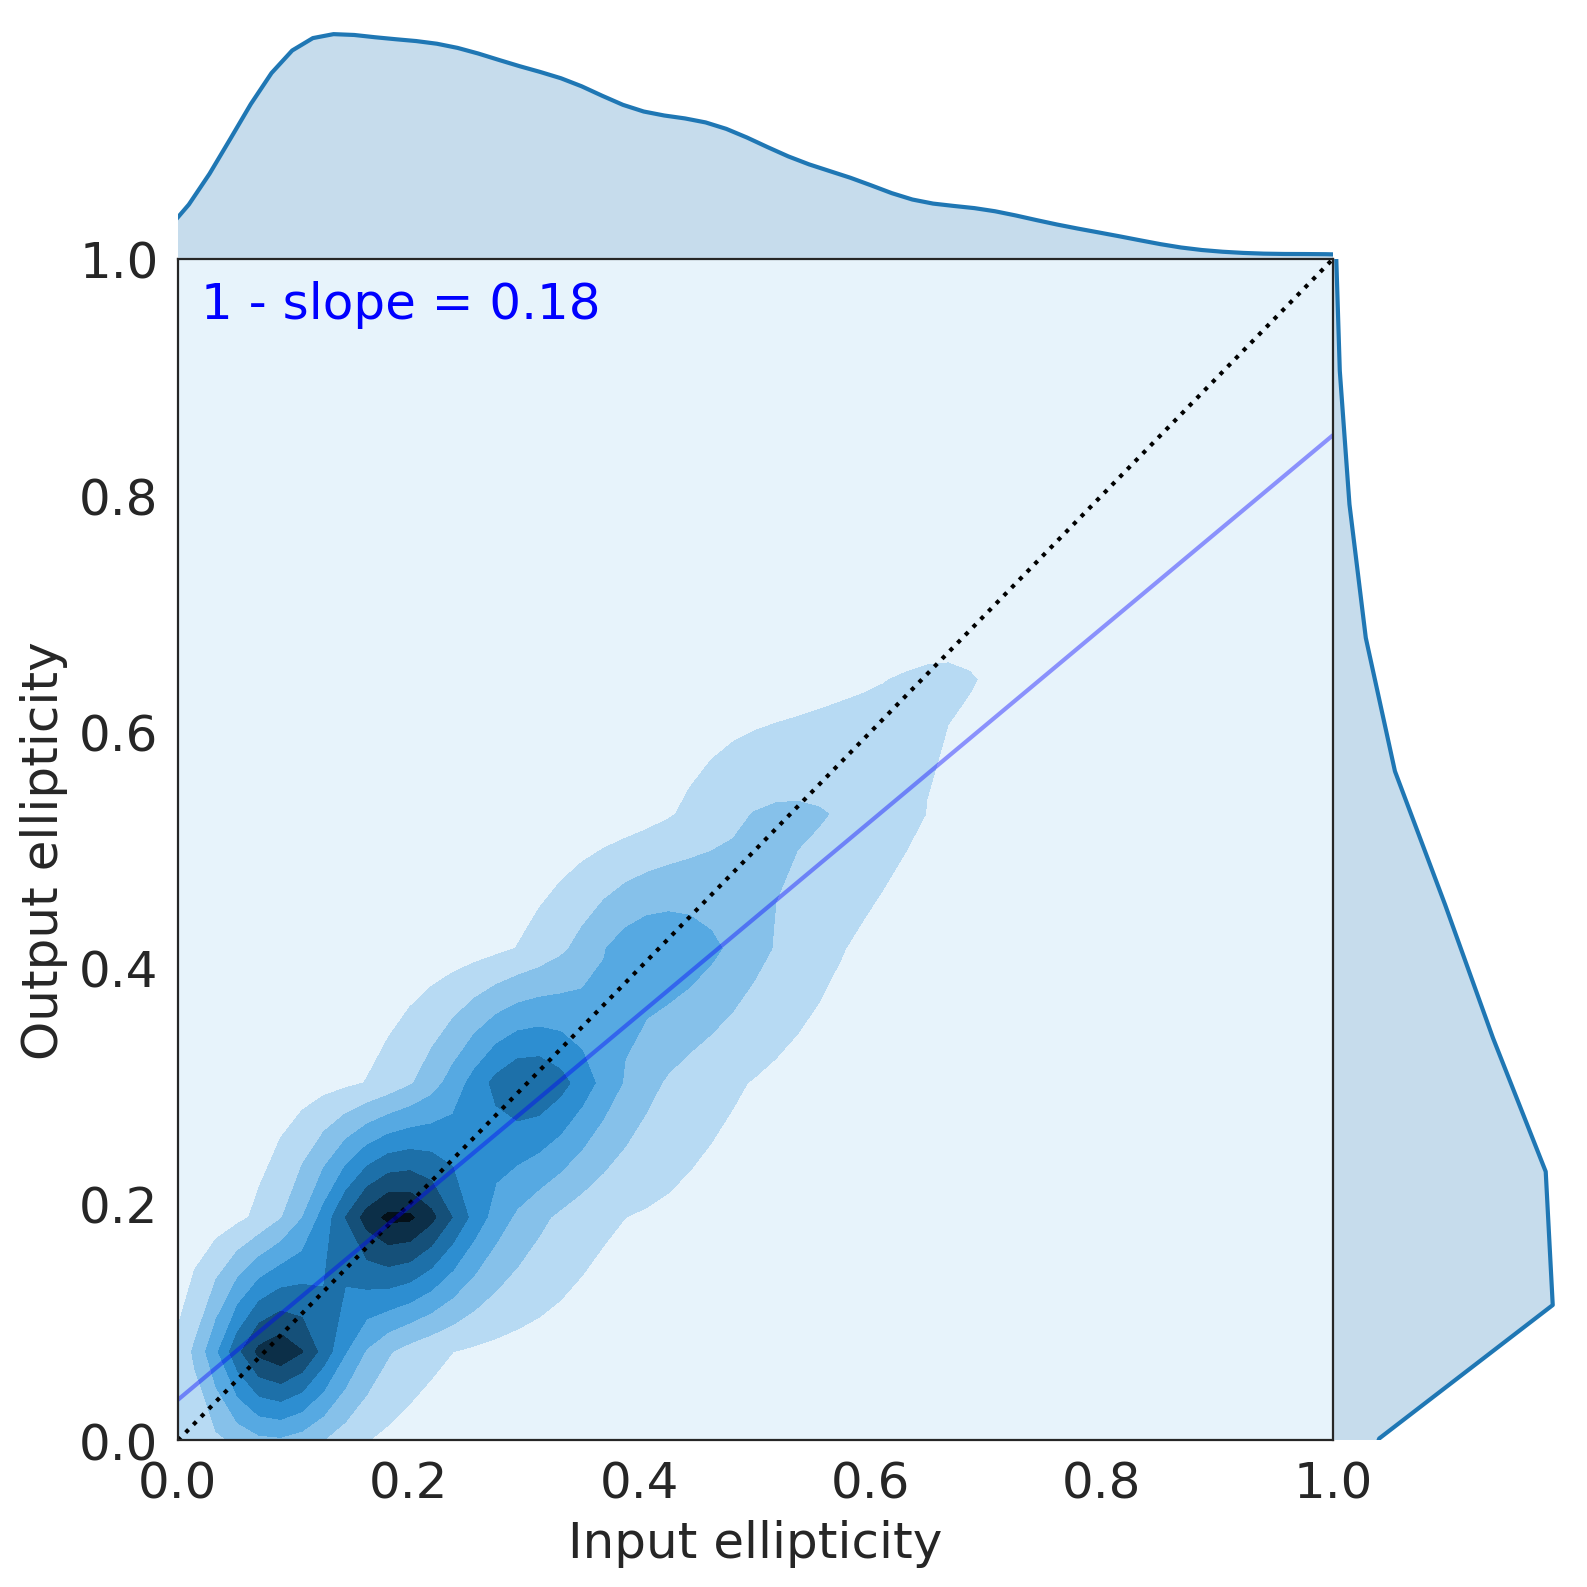

In [41]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(np.sqrt(ellipticities_lsst[:,0,0]**2+ellipticities_lsst[:,0,1]**2), np.sqrt(ellipticities_lsst[:,1,0]**2+ellipticities_lsst[:,1,1]**2), kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst*np.linspace(0, 1)+intercept_lsst, color = 'b', alpha = 0.4)
            g.ax_joint.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst, 2)), color='b')

## Flux reproduction

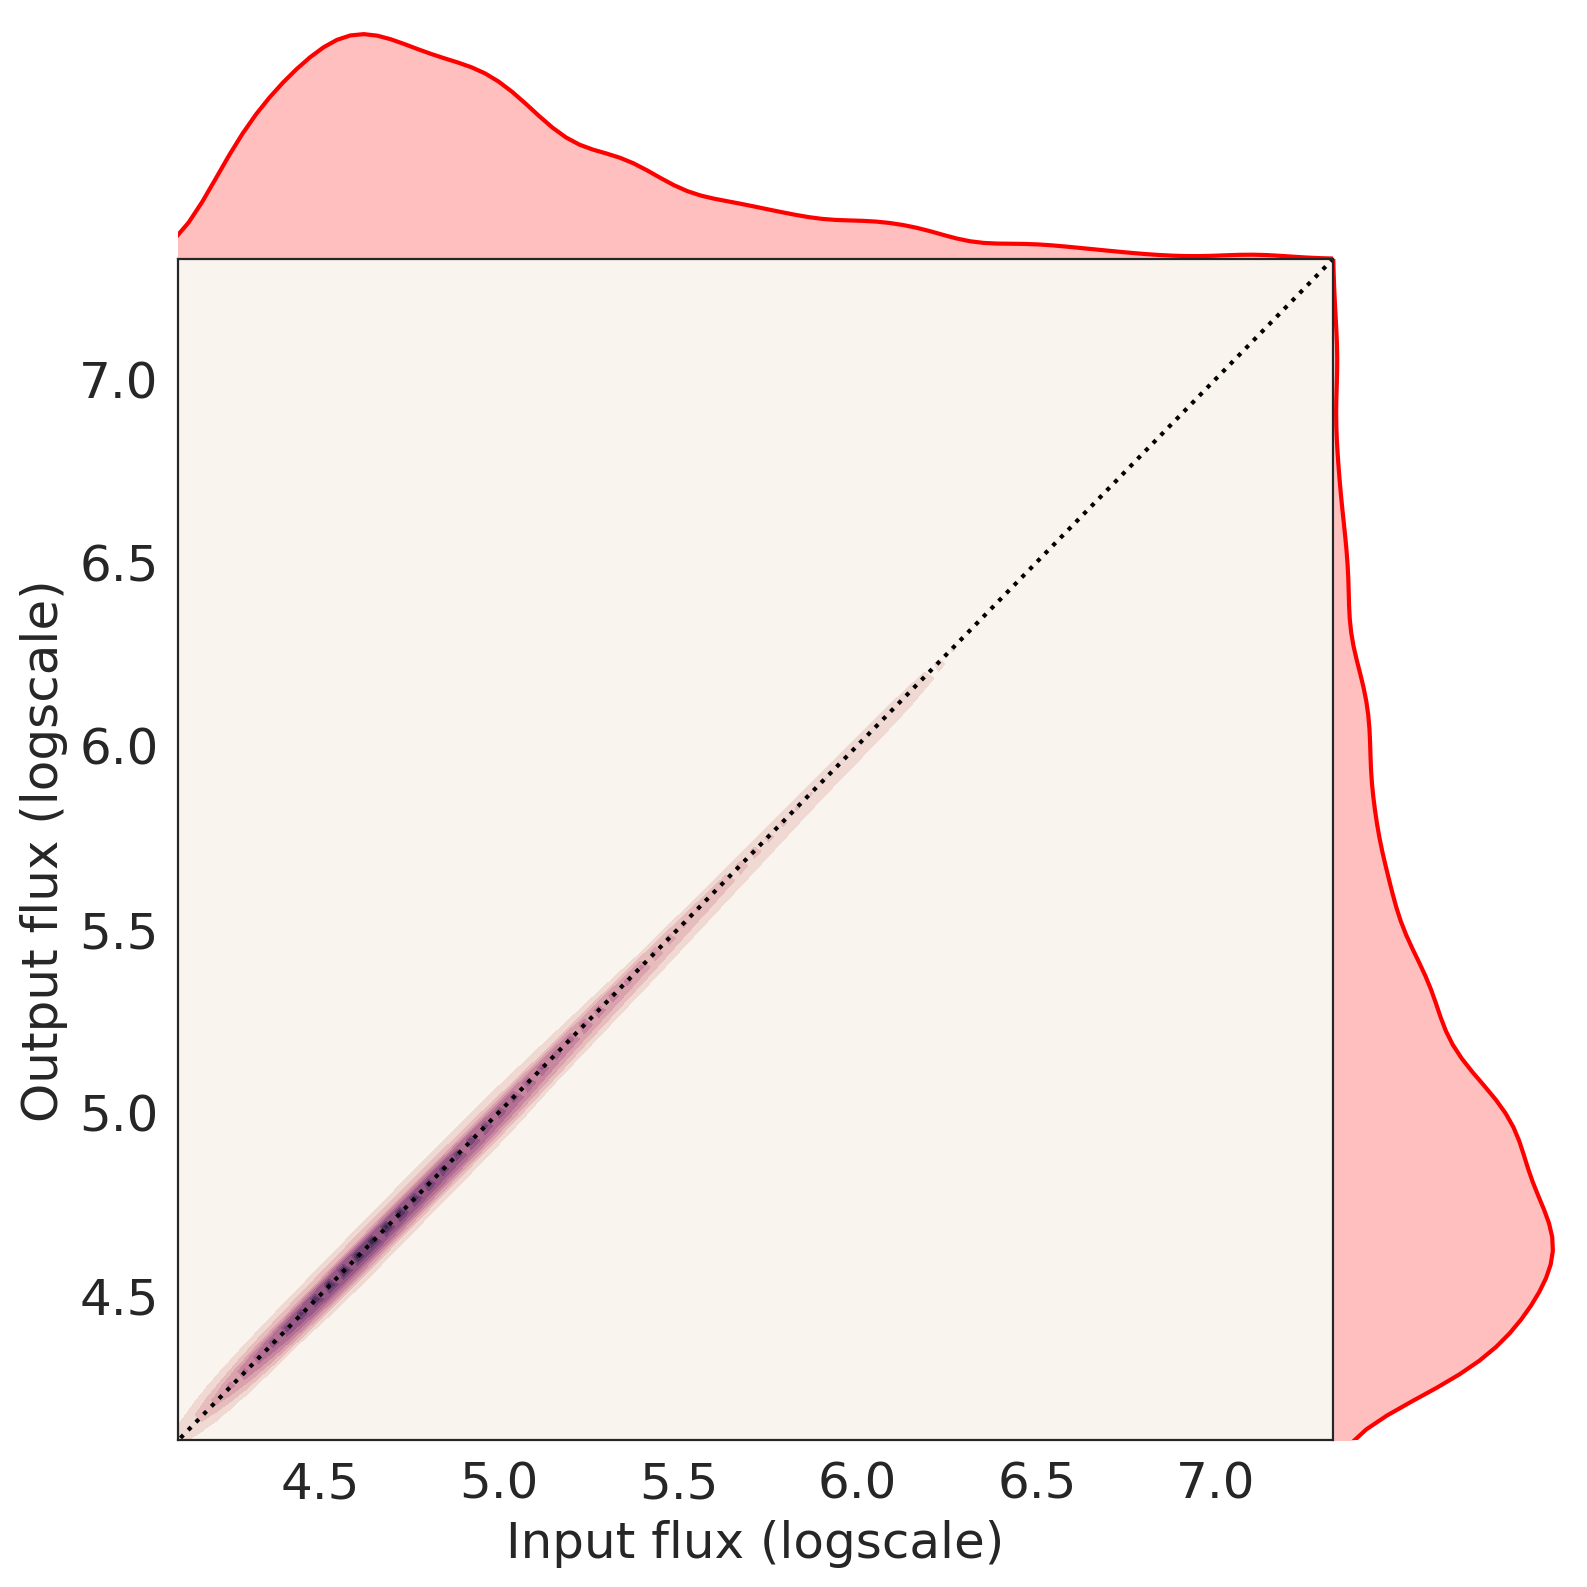

In [27]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(np.log10(flux_in_lsst), np.log10(flux_out_lsst), kind='kde',height =8,
                              xlim =[np.min(np.log10(flux_in_lsst-1000)), np.max(np.log10(flux_in_lsst))], ylim=[np.min(np.log10(flux_in_lsst-1000)), np.max(np.log10(flux_in_lsst))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst))), ':k')

# LSST + Euclid

## Shape reproduction

In [65]:
ellipticities_lsst_euclid,flux_in_lsst_euclid, flux_out_lsst_euclid = results_processing.deblender_processing(deblender_lsst_euclid,
                                                                                                                                  test_sample[0],
                                                                                                                                  bands_lsst_euclid,
                                                                                                                                  6,
                                                                                                                                  stamp_size,
                                                                                                                                  N,
                                                                                                                                  batch_size,
                                                                                                                                  psf,
                                                                                                                                  pix_scale_lsst)

0
1
2
3
4
5
6
7
8
9
10
11
12
error for galaxy 4875
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
error for galaxy 11234
29
30
31
32
error for galaxy 12811
33
34
35
error for galaxy 14042
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99



In [66]:
np.save('data/e1_e2_lsst_euclid_deb_7.npy', ellipticities_lsst_euclid)
np.save('data/flux_in_lsst_euclid_deb_7.npy', flux_in_lsst_euclid)
np.save('data/flux_out_lsst_euclid_deb_7.npy', flux_out_lsst_euclid)

In [67]:
ellipticities_lsst_euclid = np.load('data/e1_e2_lsst_euclid_deb_7.npy')
flux_in_lsst_euclid = np.load('data/flux_in_lsst_euclid_deb_7.npy')
flux_out_lsst_euclid = np.load('data/flux_out_lsst_euclid_deb_7.npy')

In [68]:
e_out_lsst_euclid = np.sqrt(ellipticities_lsst_euclid[:,1,0]**2+ellipticities_lsst_euclid[:,1,1]**2)
e_in_lsst_euclid = np.sqrt(ellipticities_lsst_euclid[:,0,0]**2+ellipticities_lsst_euclid[:,0,1]**2)

delta_e_lsst_euclid = e_out_lsst_euclid - e_in_lsst_euclid

delta_e1_lsst_euclid = ellipticities_lsst_euclid[:,1,0] - ellipticities_lsst_euclid[:,0,0]
delta_e2_lsst_euclid = ellipticities_lsst_euclid[:,1,1] - ellipticities_lsst_euclid[:,0,1]

delta_mag_lsst_euclid = -2.5*np.log10(flux_out_lsst_euclid/flux_in_lsst_euclid)

mag_in_lsst_euclid = -2.5*np.log10(flux_in_lsst_euclid)+38.4147
mag_out_lsst_euclid = -2.5*np.log10(flux_out_lsst_euclid)+38.4147

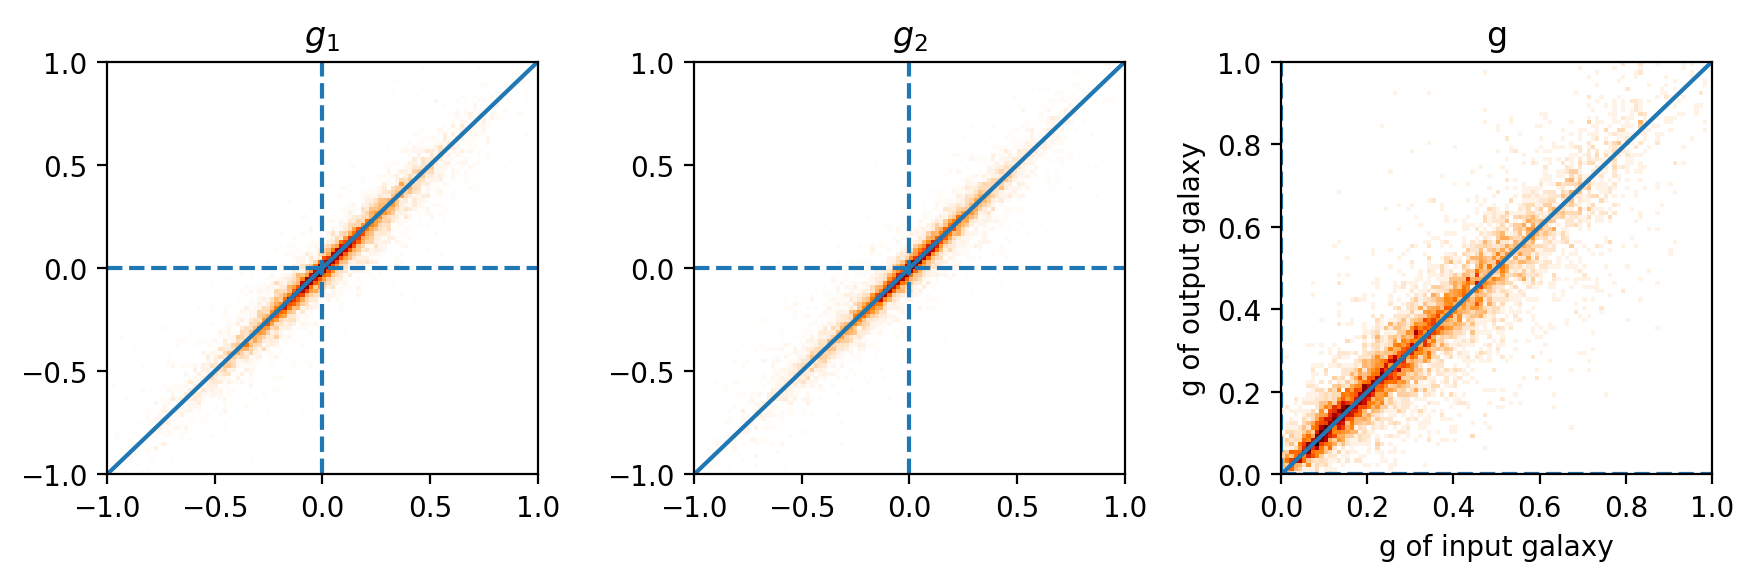

In [69]:
matplotlib.rcdefaults()

fig, axes = plt.subplots(1,3, figsize=(9,3))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_lsst_euclid[:,0,i], ellipticities_lsst_euclid[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$g_{}$'.format(i+1))#,fontsize=20)
    axes[i].spines['bottom']
    axes[i].spines['right']
    axes[i].spines['left']
    axes[i].spines['top']
    axes[i].xaxis.label
    axes[i].tick_params(axis='x')
    axes[i].tick_params(axis='y')

emax = 1
_ = axes[2].hist2d(np.sqrt(ellipticities_lsst_euclid[:,0,0]**2+ellipticities_lsst_euclid[:,0,1]**2), np.sqrt(ellipticities_lsst_euclid[:,1,0]**2+ellipticities_lsst_euclid[:,1,1]**2), bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('g'.format(i+1))#,fontsize=24)#
axes[2].tick_params(axis='x')
axes[2].tick_params(axis='y')
axes[2].set_xlabel('g of input galaxy')
axes[2].set_ylabel('g of output galaxy')

fig.tight_layout()

In [36]:
# Linear regression
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(np.sqrt(ellipticities_lsst_euclid[:,0,0]**2+ellipticities_lsst_euclid[:,0,1]**2), np.sqrt(ellipticities_lsst_euclid[:,1,0]**2+ellipticities_lsst_euclid[:,1,1]**2))

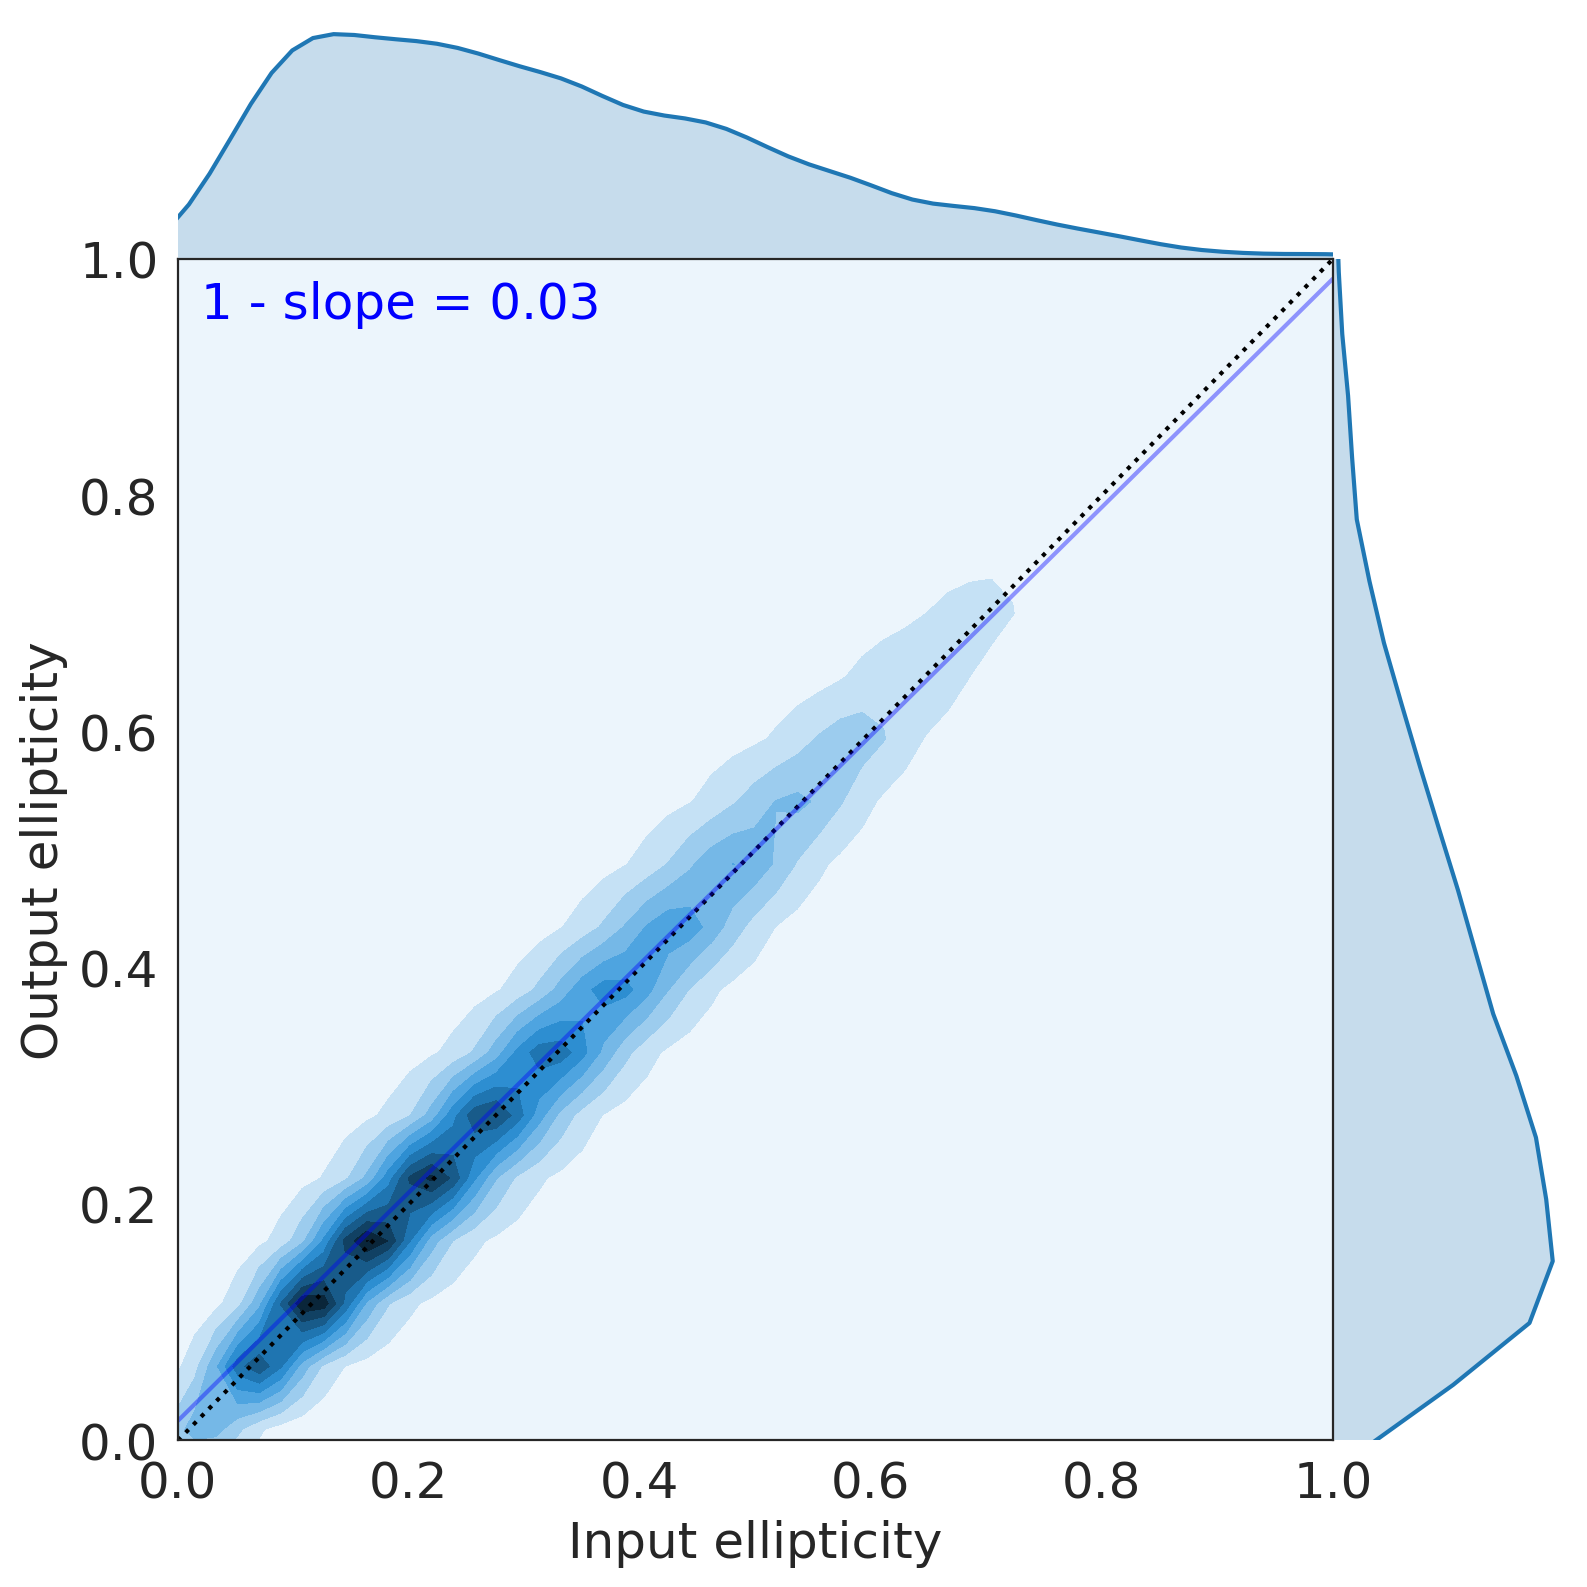

In [50]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
            
            g = sns.jointplot(np.sqrt(ellipticities_lsst_euclid[:,0,0]**2+ellipticities_lsst_euclid[:,0,1]**2), np.sqrt(ellipticities_lsst_euclid[:,1,0]**2+ellipticities_lsst_euclid[:,1,1]**2), kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0,joint_kws={'shade_lowest':True}).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst_euclid*np.linspace(0, 1)+intercept_lsst_euclid, color = 'b', alpha = 0.4)
            g.ax_joint.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst_euclid, 2)), color='b')

## Flux reproduction

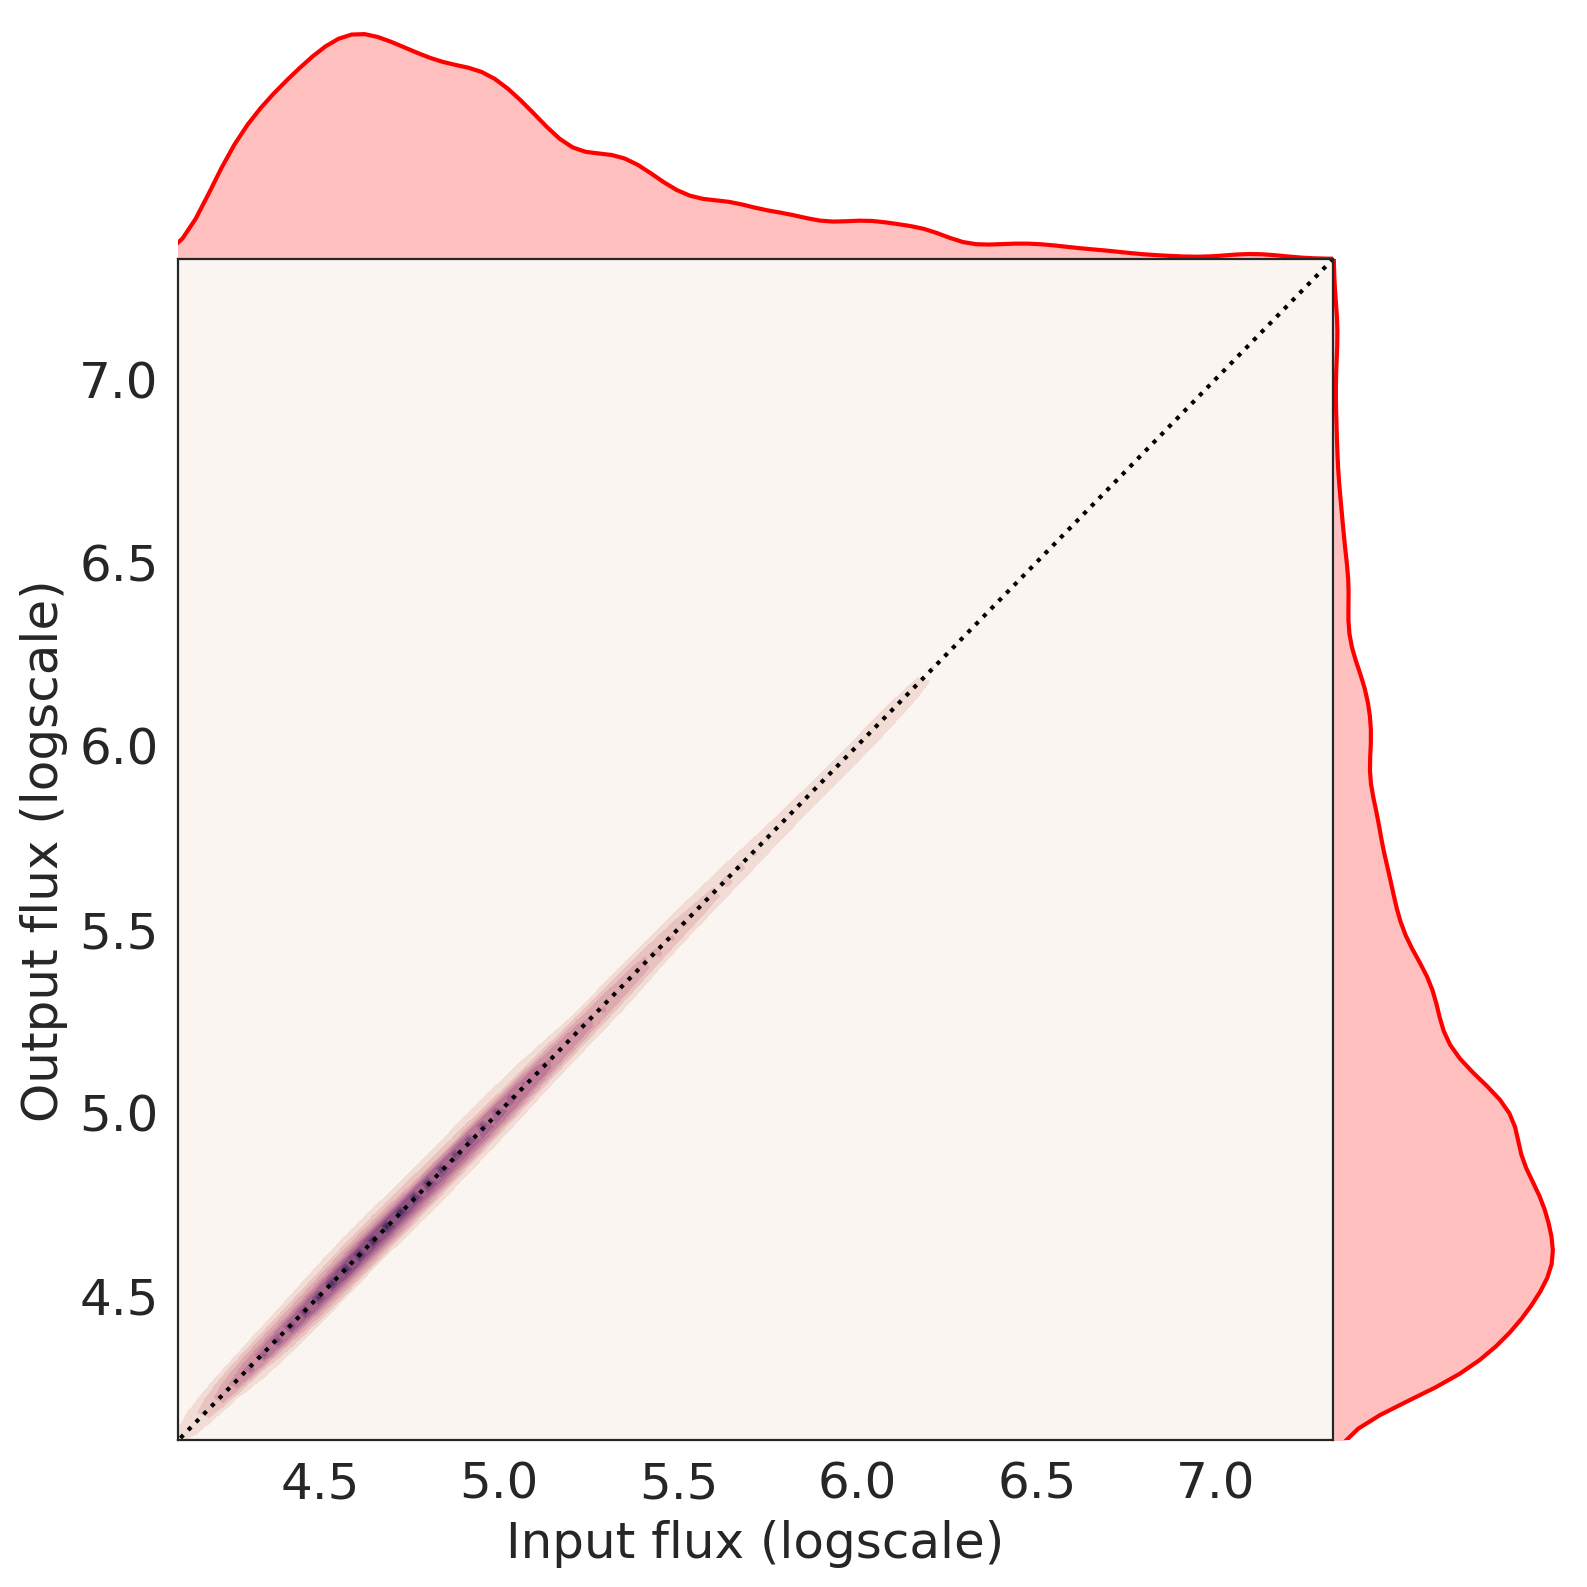

In [200]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

with sns.axes_style('white'):
            g = sns.jointplot(np.log10(flux_in_lsst_euclid), np.log10(flux_out_lsst_euclid), kind='kde',height =8,
                              xlim =[np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid))], ylim=[np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))), ':k')

# Delta WL parameters

## As function of SNR

import itertools
from matplotlib.cbook import _reshape_2D
import matplotlib.pyplot as plt
import numpy as np

# Function adapted from matplotlib.cbook
def my_boxplot_stats(X, whis=1.5, bootstrap=None, labels=None,
                  autorange=False, percents=[25, 75]):

    def _bootstrap_median(data, N=5000):
        # determine 95% confidence intervals of the median
        M = len(data)
        percentiles = [2.5, 97.5]

        bs_index = np.random.randint(M, size=(N, M))
        bsData = data[bs_index]
        estimate = np.median(bsData, axis=1, overwrite_input=True)

        CI = np.percentile(estimate, percentiles)
        return CI

    def _compute_conf_interval(data, med, iqr, bootstrap):
        if bootstrap is not None:
            # Do a bootstrap estimate of notch locations.
            # get conf. intervals around median
            CI = _bootstrap_median(data, N=bootstrap)
            notch_min = CI[0]
            notch_max = CI[1]
        else:

            N = len(data)
            notch_min = med - 1.57 * iqr / np.sqrt(N)
            notch_max = med + 1.57 * iqr / np.sqrt(N)

        return notch_min, notch_max

    # output is a list of dicts
    bxpstats = []

    # convert X to a list of lists
    X = _reshape_2D(X, "X")

    ncols = len(X)
    if labels is None:
        labels = itertools.repeat(None)
    elif len(labels) != ncols:
        raise ValueError("Dimensions of labels and X must be compatible")

    input_whis = whis
    for ii, (x, label) in enumerate(zip(X, labels)):

        # empty dict
        stats = {}
        if label is not None:
            stats['label'] = label

        # restore whis to the input values in case it got changed in the loop
        whis = input_whis

        # note tricksyness, append up here and then mutate below
        bxpstats.append(stats)

        # if empty, bail
        if len(x) == 0:
            stats['fliers'] = np.array([])
            stats['mean'] = np.nan
            stats['med'] = np.nan
            stats['q1'] = np.nan
            stats['q3'] = np.nan
            stats['cilo'] = np.nan
            stats['cihi'] = np.nan
            stats['whislo'] = np.nan
            stats['whishi'] = np.nan
            stats['med'] = np.nan
            continue

        # up-convert to an array, just to be safe
        x = np.asarray(x)

        # arithmetic mean
        stats['mean'] = np.mean(x)

        # median
        med = np.percentile(x, 50)
        ## Altered line
        q1, q3 = np.percentile(x, (percents[0], percents[1]))

        # interquartile range
        stats['iqr'] = q3 - q1
        if stats['iqr'] == 0 and autorange:
            whis = 'range'

        # conf. interval around median
        stats['cilo'], stats['cihi'] = _compute_conf_interval(
            x, med, stats['iqr'], bootstrap
        )

        # lowest/highest non-outliers
        if np.isscalar(whis):
            if np.isreal(whis):
                loval = q1 - whis * stats['iqr']
                hival = q3 + whis * stats['iqr']
            elif whis in ['range', 'limit', 'limits', 'min/max']:
                loval = np.min(x)
                hival = np.max(x)
            else:
                raise ValueError('whis must be a float, valid string, or list '
                                 'of percentiles')
        else:
            loval = np.percentile(x, whis[0])
            hival = np.percentile(x, whis[1])

        # get high extreme
        wiskhi = np.compress(x <= hival, x)
        if len(wiskhi) == 0 or np.max(wiskhi) < q3:
            stats['whishi'] = q3
        else:
            stats['whishi'] = np.max(wiskhi)

        # get low extreme
        wisklo = np.compress(x >= loval, x)
        if len(wisklo) == 0 or np.min(wisklo) > q1:
            stats['whislo'] = q1
        else:
            stats['whislo'] = np.min(wisklo)

        # compute a single array of outliers
        stats['fliers'] = np.hstack([
            np.compress(x < stats['whislo'], x),
            np.compress(x > stats['whishi'], x)
        ])

        # add in the remaining stats
        stats['q1'], stats['med'], stats['q3'] = q1, med, q3

    return bxpstats

def boxplot(df_in, x, y, z,
            xlim, ylim, ylim2, 
            x_scale, 
            legend,
            x_label, y_label, y_label_hist, y_label_2,
            errors = None,
            legend_remove = False,
            palette = ["#3498db","#e74c3c"],
            nbins = 11):
    
    median = []
    q1 = []
    q3 = []
    whislo = []
    whishi = []
    
    import matplotlib as mpl
    mpl.rcdefaults()
    
    if errors is not None:
        df_plot = df_in.drop(errors)
    else:
        df_plot = df_in
    df_plot = df_plot.dropna()
        
    if x_scale == 'log':
        x_bins = np.geomspace(xlim[0], xlim[1], nbins+1)
    else :
        x_bins = np.linspace(xlim[0], xlim[1], nbins+1)
    
    x_bins[0] -= 1e-5
    x_bins[-1] += 1e-5
    
    idx = np.digitize(df_plot[x], x_bins)    

    fig, axes = plt.subplots(3,1, figsize=(5,4), gridspec_kw={'height_ratios': [1, 3, 1]})
    
    if x_scale == 'log':
        sns.distplot(np.log10(df_plot[x]), ax=axes[0], color='0.8')
        axes[0].set_xlim(np.log10(xlim[0]), np.log10(xlim[1]))
    else:
        sns.distplot(df_plot[x], ax=axes[0], color='0.8')
        axes[0].set_xlim(xlim[0], xlim[1])
    
    axes[0].set_yticks([])
    axes[0].set_ylabel(y_label_hist)
    axes[0].set_xticks([])

    ax = axes[1]
    exp = np.unique(df_plot[z])
    N_exp = len(exp)
    print(exp)
    handles = []
    for ik, key in enumerate(exp):
        print(ik, key)
        stats = {}
        for i in range(1,len(x_bins)):
            stats[i] = my_boxplot_stats(df_plot[y][np.logical_and(idx==i,df_plot[z]==key)].values, whis=[100*scipy.stats.norm.cdf(-2),100*scipy.stats.norm.cdf(2)], percents=[100*scipy.stats.norm.cdf(-1),100*scipy.stats.norm.cdf(1)])[0]
            median.append(stats[i]['med'])
            q1.append(stats[i]['q1'])
            q3.append(stats[i]['q3'])
            whislo.append(stats[i]['whislo'])
            whishi.append(stats[i]['whishi'])
        # Plot boxplots from our computed statistics
        bp = ax.bxp([stats[i] for i in range(1,len(x_bins))],
                    positions=np.arange(len(x_bins)-1)+.5+0.9*(ik-(N_exp-1.)/2.)/N_exp,
                    widths=0.7/len(np.unique(df_plot[z])),
                    showfliers=False,
                    patch_artist=True,
                    boxprops={'facecolor':(*mpl.colors.to_rgba(palette[ik])[:3],0.25), 'edgecolor':palette[ik]})

        handles.append(bp['boxes'][0])

        # Colour the lines in the boxplot blue
        for element in bp.keys():
            if element != 'boxes':
                plt.setp(bp[element], color=palette[ik])
        
    if not legend_remove:
        ax.legend(handles, legend, frameon=False, loc ='upper right', borderpad = 0.1, fontsize = 10)
    ax.axhline(y=0, c='0.5', zorder=32, lw=0.5)
    ax.set_xlim(0,len(x_bins)-1)
    ax.set_ylabel(y_label)
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xticks([])
    ax = ax.twiny()
    ax.set_xlim(xlim[0], xlim[1])
    if x_scale == 'log':
        ax.set_xscale('log')
    #ax.tick_params(
    #    axis='x',          # changes apply to the x-axis
    #    which='both',      # both major and minor ticks are affected
    #    bottom=False,      # ticks along the bottom edge are off
    #    top=False,         # ticks along the top edge are off
    #    labelbottom=False)    
    ax.set_xticks([])
    ax.xaxis.tick_bottom()
    
    ax = axes[2]
    #ax = ax.twiny()
    ax.axhline(y=0, c='0.5', zorder=32, lw=0.5)
    med_array = np.array(median).reshape(N_exp,int(len(median)/N_exp))
    for ik, key in enumerate(exp):
        ax.plot(np.repeat(x_bins,2)[1:-1], np.repeat(med_array[ik],2), c=palette[ik])
    ax.set_xlim(xlim[0], xlim[1])
    if x_scale == 'log':
        ax.set_xscale('log')
    ax.set_xlabel(x_label)
    ax.set_ylim(ylim2)
    ax.set_ylabel(y_label_2)
    ax.xaxis.tick_bottom()
            
    fig.align_ylabels(axes)    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    
    return fig , median , q1, q3, whislo, whishi

In [178]:
df_plot = pd.DataFrame()


frames = [df,df,df,df,df,df,df,df]
df_plot = pd.concat(frames, ignore_index=True)

print(ellipticities_lsst[:,1,0].shape, df_plot.shape, ellipticities_lsst_euclid[:,1,0].shape)

df_plot['e1_out'] = np.concatenate((ellipticities_lsst[:,1,0],ellipticities_lsst_euclid[:,1,0]))
df_plot['e2_out'] = np.concatenate((ellipticities_lsst[:,1,1],ellipticities_lsst_euclid[:,1,1]))
df_plot['e_error'] = np.concatenate((delta_e_lsst, delta_e_lsst_euclid))
df_plot['e1_error'] = np.concatenate((delta_e1_lsst, delta_e1_lsst_euclid))
df_plot['e2_error'] = np.concatenate((delta_e2_lsst, delta_e2_lsst_euclid))
df_plot['mag_error'] = np.concatenate((delta_mag_lsst, delta_mag_lsst_euclid))
df_plot['e_out'] = np.concatenate((np.sqrt(ellipticities_lsst[:,0,0]**2+ellipticities_lsst[:,0,1]**2), 
                                  np.sqrt(ellipticities_lsst_euclid[:,0,0]**2+ellipticities_lsst_euclid[:,0,1]**2)))

df_plot['e_in'] = np.concatenate((np.sqrt(ellipticities_lsst[:,1,0]**2+ellipticities_lsst[:,1,1]**2), 
                                  np.sqrt(ellipticities_lsst_euclid[:,1,0]**2+ellipticities_lsst_euclid[:,1,1]**2)))

df_plot['exp'] = ['LSST']*len(df)*4 + ['LSST+Euclid']*len(df)*4
df_plot['delta_mag_closest'] =  df_plot['closest_mag'] - df_plot['mag']

select = (-1.<df_plot['e1']) & (df_plot['e1']<1.) & (-1.<df_plot['e2']) & (df_plot['e2']<1.) &(-1.<df_plot['e1_out']) & (df_plot['e1_out']<1.) & (-1.<df_plot['e2_out']) & (df_plot['e2_out']<1.)
df_plot = df_plot[select]

#df_plot['delta_mag_closest'] =  df['closest_mag'] - df['mag']

(40000,) (80000, 22) (40000,)


In [70]:
df_plot = pd.DataFrame()


frames = [df]
df_plot = pd.concat([df,df], ignore_index=True)

print(ellipticities_lsst[:,1,0].shape, df_plot.shape, ellipticities_lsst_euclid[:,1,0].shape)

df_plot['e1_out'] = np.concatenate((ellipticities_lsst[:,1,0],ellipticities_lsst_euclid[:,1,0]))
df_plot['e2_out'] = np.concatenate((ellipticities_lsst[:,1,1],ellipticities_lsst_euclid[:,1,1]))
df_plot['e_error'] = np.concatenate((delta_e_lsst, delta_e_lsst_euclid))
df_plot['e1_error'] = np.concatenate((delta_e1_lsst, delta_e1_lsst_euclid))
df_plot['e2_error'] = np.concatenate((delta_e2_lsst, delta_e2_lsst_euclid))
df_plot['mag_error'] = np.concatenate((delta_mag_lsst, delta_mag_lsst_euclid))
df_plot['e_out'] = np.concatenate((np.sqrt(ellipticities_lsst[:,0,0]**2+ellipticities_lsst[:,0,1]**2), 
                                  np.sqrt(ellipticities_lsst_euclid[:,0,0]**2+ellipticities_lsst_euclid[:,0,1]**2)))

df_plot['e_in'] = np.concatenate((np.sqrt(ellipticities_lsst[:,1,0]**2+ellipticities_lsst[:,1,1]**2), 
                                  np.sqrt(ellipticities_lsst_euclid[:,1,0]**2+ellipticities_lsst_euclid[:,1,1]**2)))

df_plot['exp'] = ['LSST']*10000 + ['LSST+Euclid']*10000
df_plot['delta_mag_closest'] =  df_plot['closest_mag'] - df_plot['mag']

select = (-1.<df_plot['e1']) & (df_plot['e1']<1.) & (-1.<df_plot['e2']) & (df_plot['e2']<1.) &(-1.<df_plot['e1_out']) & (df_plot['e1_out']<1.) & (-1.<df_plot['e2_out']) & (df_plot['e2_out']<1.)
df_plot = df_plot[select]

(10000,) (20000, 22) (10000,)


### Error on ellipticity

In [71]:
np.min(df_plot['SNR'])

6.343976407333492

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


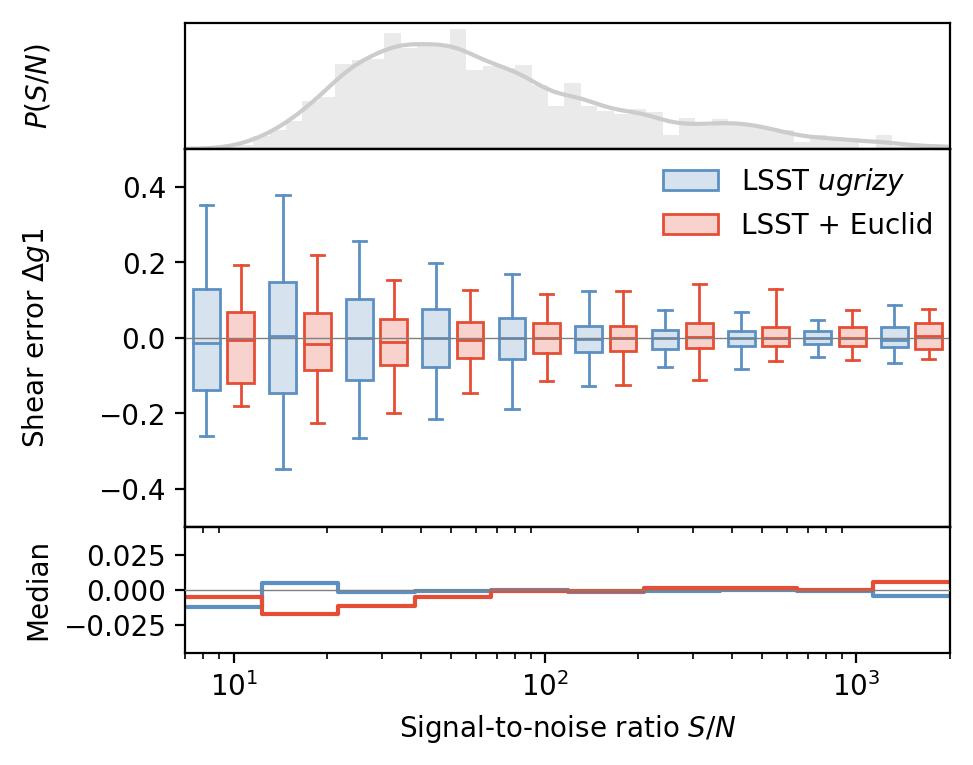

In [72]:
fig = boxplot(df_plot, x = 'SNR', y = 'e1_error', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.5, 0.5), 
              ylim2= (-0.045, 0.045),
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Shear error $\\Delta g1$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'Median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

#fig.savefig('figures/e_snr.pdf')

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


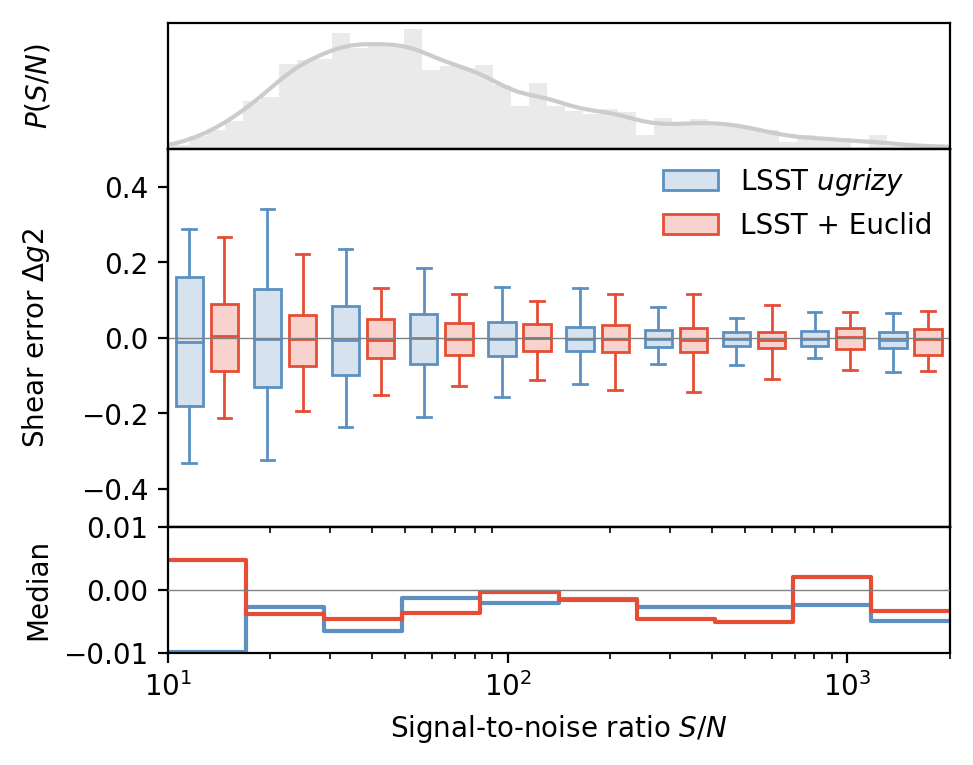

In [73]:
fig = boxplot(df_plot, x = 'SNR', y = 'e2_error', z = 'exp',
              xlim = (10, 2000),
              ylim = (-0.5, 0.5),
              ylim2= (-0.01, 0.01),
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Shear error $\\Delta g2$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'Median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

#fig.savefig('figures/e_snr.pdf')

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


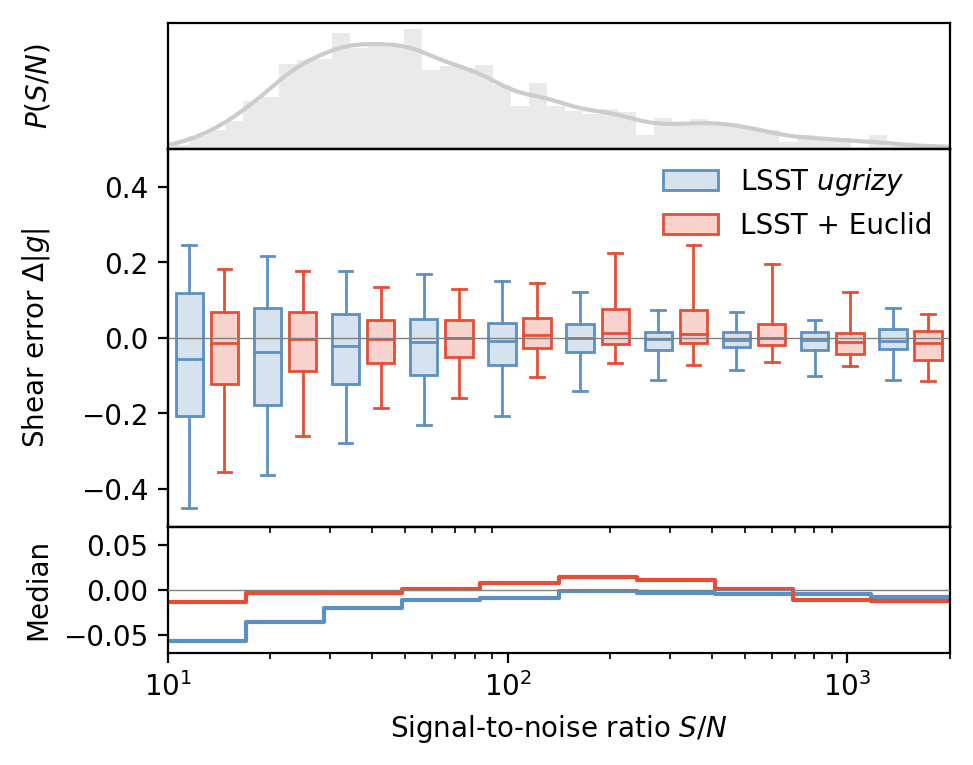

In [94]:
fig = boxplot(df_plot, x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (10, 2000),
              ylim = (-0.5, 0.5),
              ylim2= (-0.07, 0.07),
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal-to-noise ratio $S/N$', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'Median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_snr_2.pdf')

Magnitude error as function of S/N

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


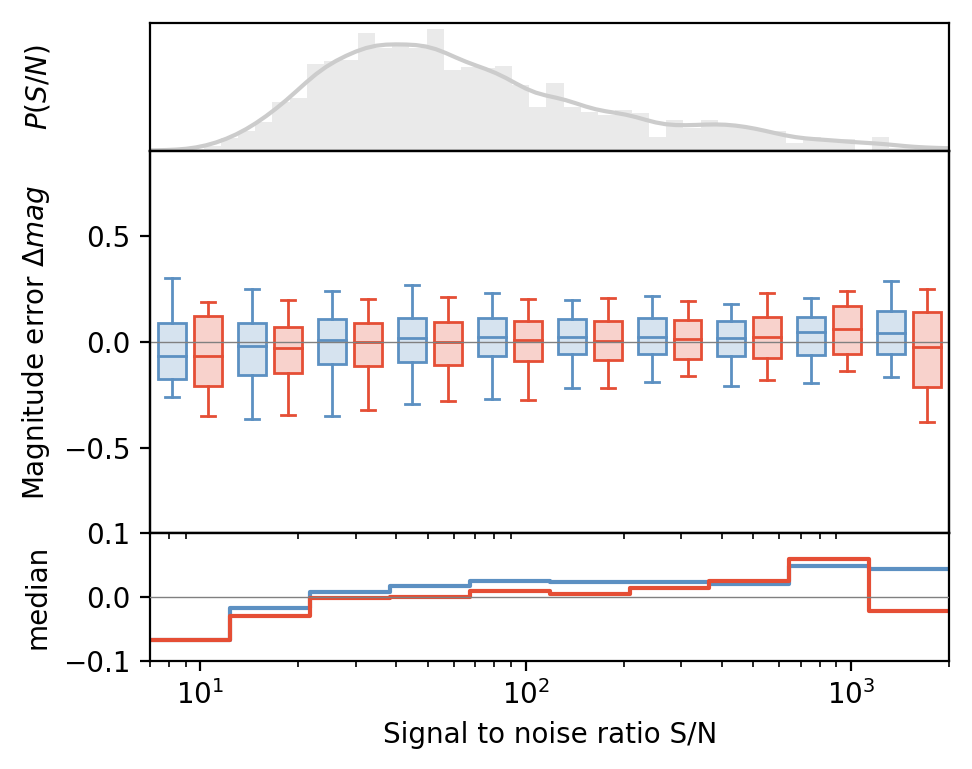

In [96]:
fig = boxplot(df_plot, x = 'SNR', y = 'mag_error', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_snr_2.pdf')

### Error on flux

In [76]:
np.max(df_plot['mag'])

27.996071897478828

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


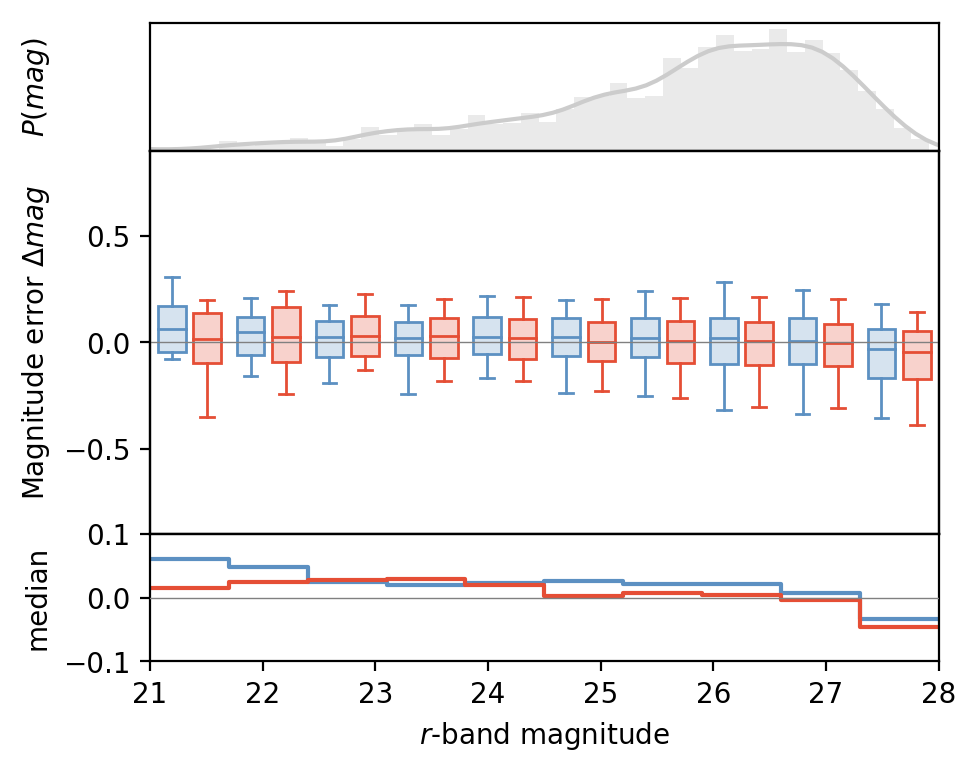

In [97]:
fig = boxplot(df_plot, x = 'mag', y = 'mag_error', z = 'exp',
              xlim = (21., 28.),
              ylim = (-0.9,0.9), 
              ylim2 = (-0.1,0.1), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='$r$-band magnitude', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_mag_2.pdf')

## As a function of blend rate

### As a function of blend rate with closest

#### Error on ellipticity

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


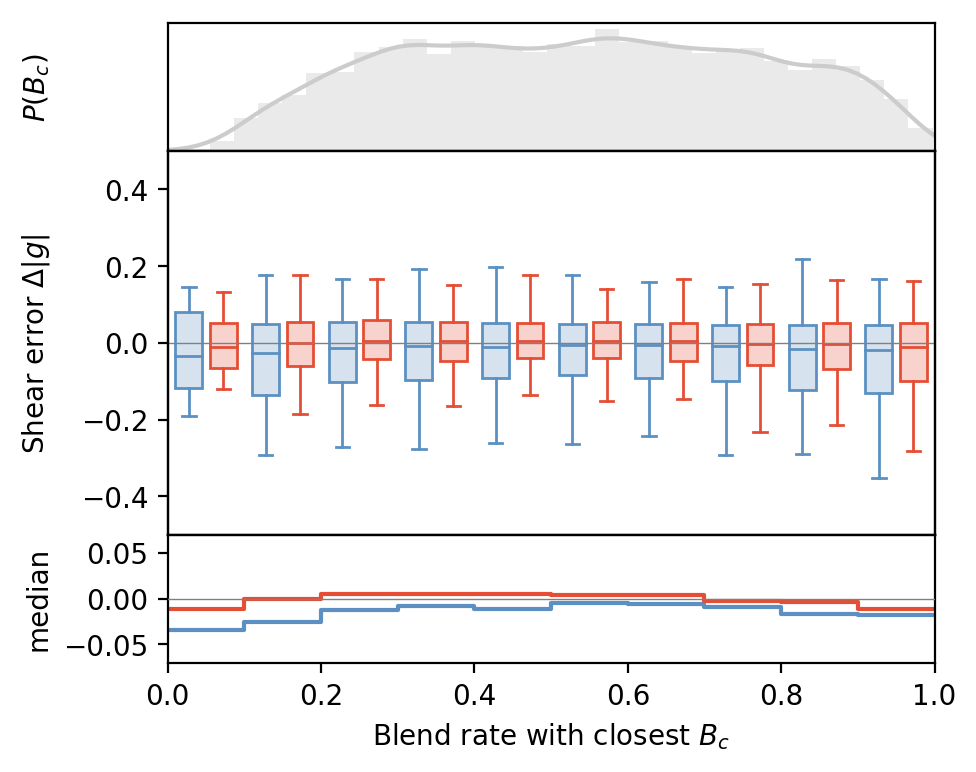

In [98]:
fig = boxplot(df_plot, x = 'blendedness_closest_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 1.),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blend rate with closest $B_c$', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(B_c)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_b_c_2.pdf')

#### Error on flux

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


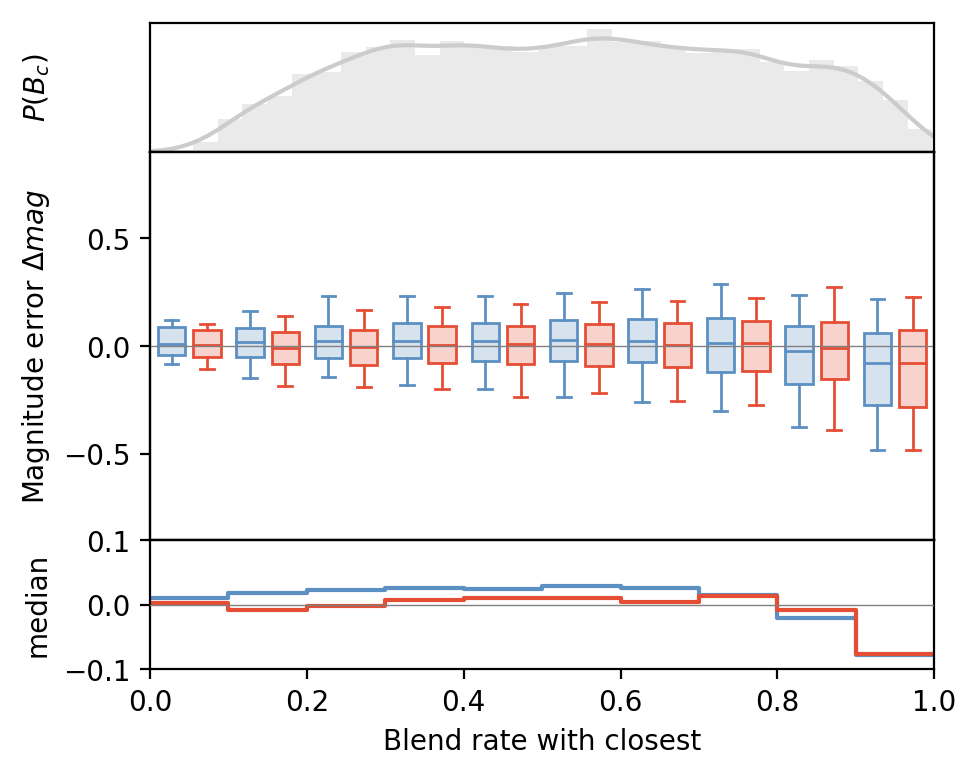

In [99]:
fig = boxplot(df_plot, x = 'blendedness_closest_lsst', y = 'mag_error', z = 'exp',
              xlim = (0., 1.),
              ylim = (-0.9,0.9), 
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blend rate with closest', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_c)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_b_c_2.pdf')

### As a function of total blend rate

#### Error on ellipticity

In [53]:
np.max(df['blendedness_total_lsst'])

0.764361172914505

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


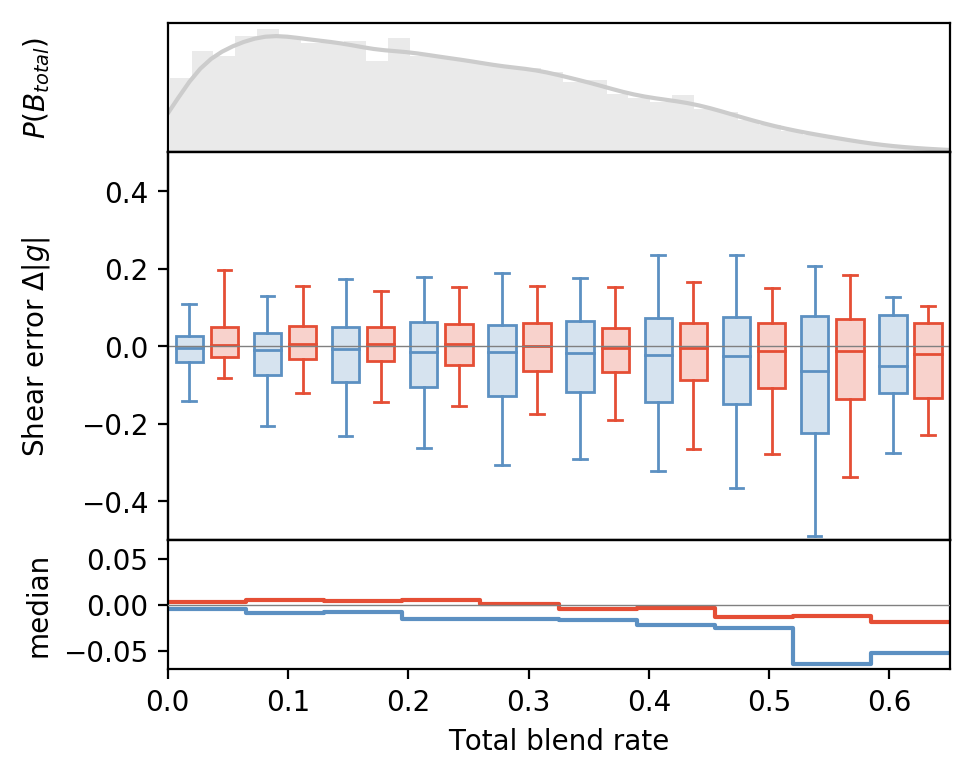

In [100]:
fig = boxplot(df_plot, x = 'blendedness_total_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.65),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Total blend rate', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(B_{total})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_b_tot_2.pdf')

#### Error on flux

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


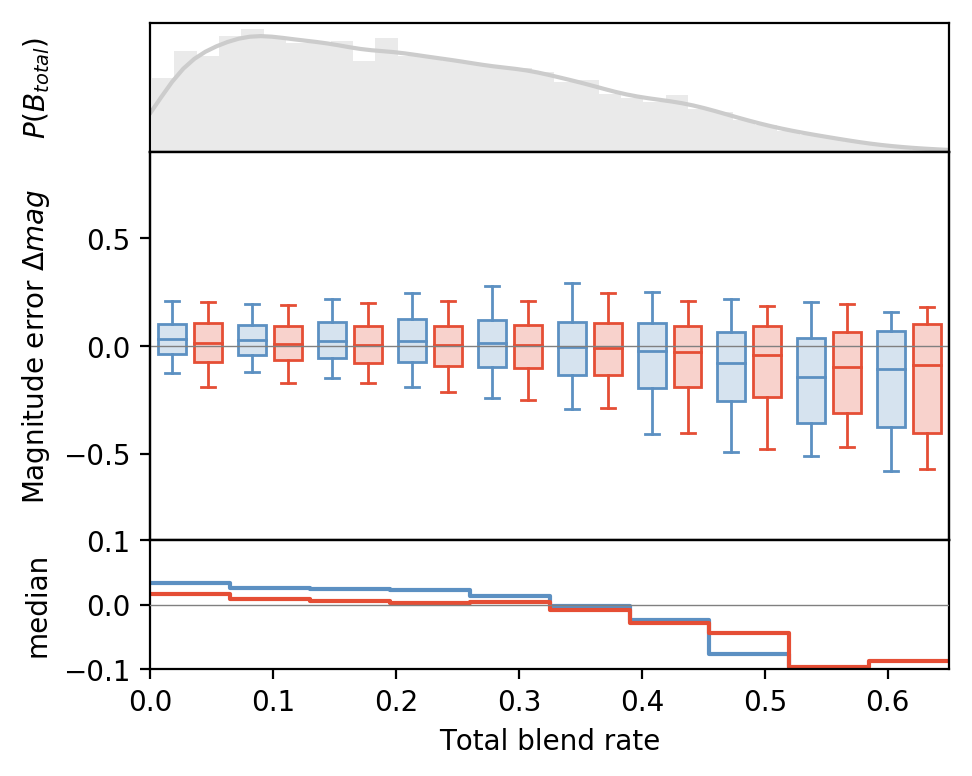

In [101]:
fig = boxplot(df_plot, x = 'blendedness_total_lsst', y = 'mag_error', z = 'exp',
              xlim = (0., .65),
              ylim = (-0.9,0.9), 
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Total blend rate', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_{total})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_b_tot_2.pdf')

## As a function of aperture blending fraction

### Error on ellipticity

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


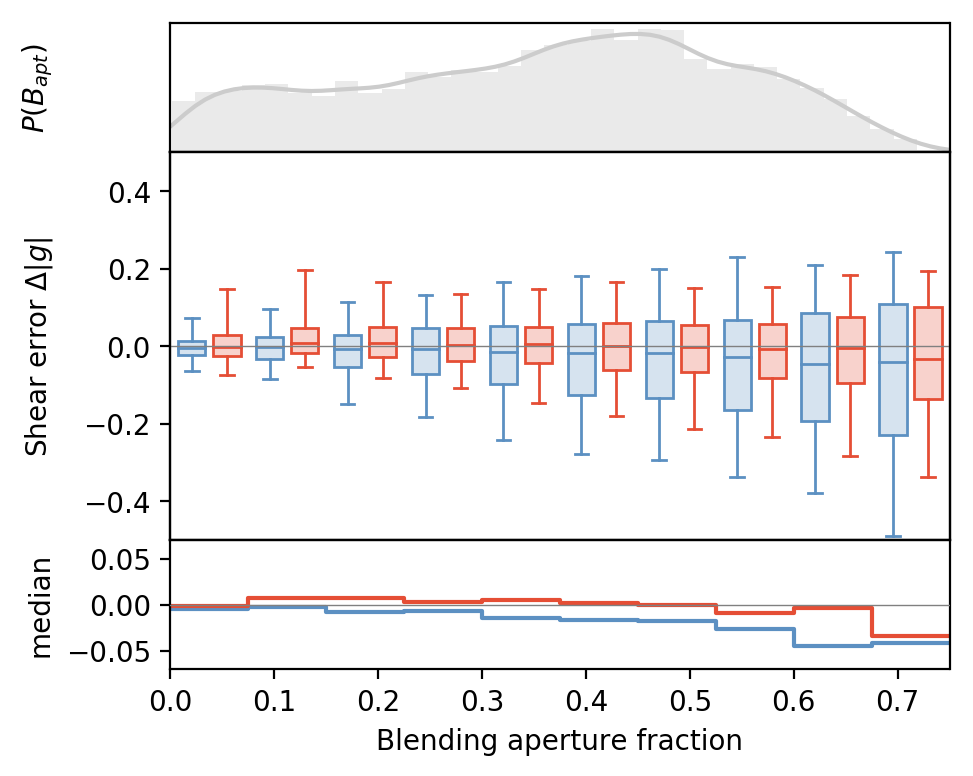

In [102]:
fig = boxplot(df_plot, x = 'blendedness_aperture_lsst', y = 'e_error', z = 'exp',
              xlim = (0., 0.75),
              ylim = (-0.5,0.5),
              ylim2 = (-0.07,0.07),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blending aperture fraction', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(B_{apt})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_b_apt_2.pdf')

### Error on magnitude

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


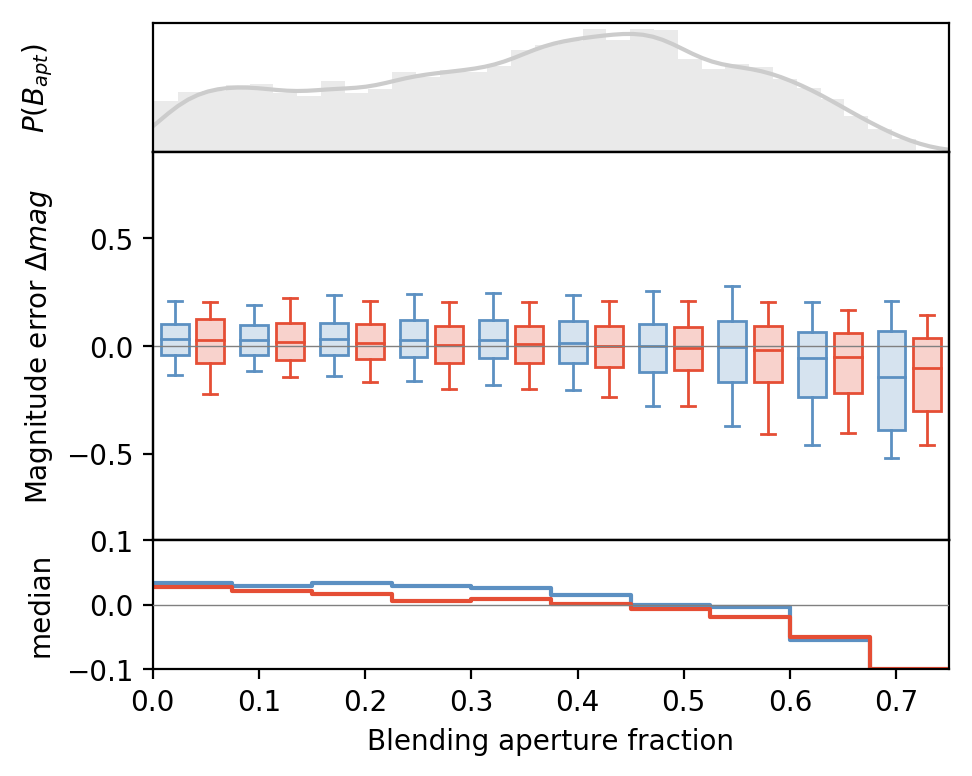

In [103]:
fig = boxplot(df_plot, x = 'blendedness_aperture_lsst', y = 'mag_error', z = 'exp',
              xlim = (0., .75),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Blending aperture fraction', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(B_{apt})$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_b_apt_2.pdf')

## As a function of delta magnitude

### Error on ellipticity

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


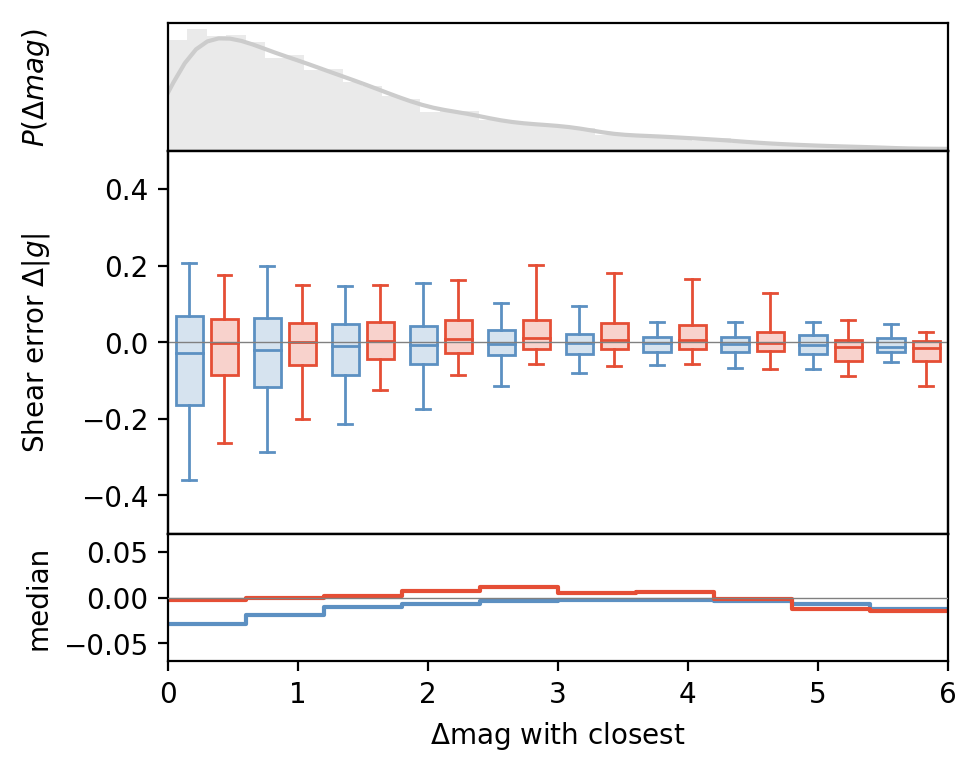

In [104]:
fig = boxplot(df_plot, x = 'delta_mag_closest', y = 'e_error', z = 'exp',
              xlim = (0., 6.),
              ylim = (-0.5,0.5), 
              ylim2 = (-0.07,0.07), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='$\Delta$mag with closest', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(\\Delta mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/e_mag_c_2.pdf')

### Error on flux

['LSST' 'LSST+Euclid']
0 LSST
1 LSST+Euclid


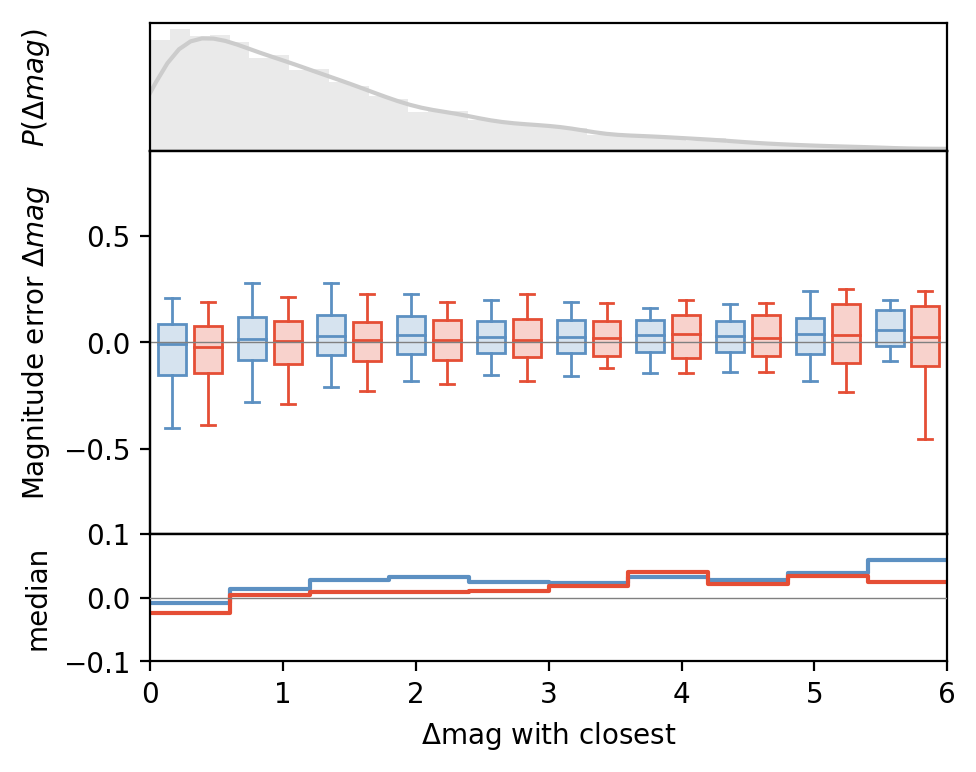

In [105]:
fig = boxplot(df_plot, x = 'delta_mag_closest', y = 'mag_error', z = 'exp',
              xlim = (0., 6.),
              ylim = (-0.9,0.9),
              ylim2 = (-0.1,0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='$\Delta$mag with closest', 
              y_label = 'Magnitude error $\\Delta mag$',
              y_label_hist='$P(\\Delta mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),
              nbins = 10)

fig[0].savefig('figures/mag_mag_c_2.pdf')

# N sampling for the same galaxy on few blended images

In [112]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [113]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

In [114]:
reload(generator)

<module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>

In [115]:
list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)

NameError: name 'batch_gen_lsst_euclid' is not defined

In [ ]:
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

flux_out_lsst = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
flux_out_lsst_euclid = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
input_noiseless = []
input_noisy = []
output_deblender = []
output_deblender_lsst_euclid = []
blend_rate = []
nb_of_gal = []
err_count = 0

# Measurement of fluxes
mask = plot.createCircularMask(stamp_size,stamp_size,None,5)


for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    input_noiseless.append(denorm(list_galsim_simple[1], bands_lsst_euclid, channel_last = True))
    
    plt.imshow(list_galsim_simple[0][0][:,:,2])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    #try: 
    print(i)
    for j in range (nb_of_samplings):
        print(j)
        output_vae_list_lsst = deblender_lsst.predict(list_galsim_simple[0][:,:,:,4:], batch_size = batch_size)
        output_vae_list_lsst = denorm (output_vae_list_lsst, bands_lsst, channel_last = True)
        
        output_vae_list_lsst_euclid = deblender_lsst_euclid.predict(list_galsim_simple[0][:,:,:], batch_size = batch_size)
        output_vae_list_lsst_euclid = denorm (output_vae_list_lsst_euclid, bands_lsst_euclid, channel_last = True)
        
        if j == (nb_of_samplings-1) :  
            input_noisy.append(denorm(list_galsim_simple[0], bands_lsst_euclid, channel_last = True))
            output_deblender.append(output_vae_list_lsst)
            output_deblender_lsst_euclid.append(output_vae_list_lsst_euclid)
            blend_rate.append(list_galsim_simple[7][0])
            nb_of_gal.append(len(list_galsim_simple[5]))

        for t in range (batch_size):
            img_out_simple = galsim.Image(output_vae_list_lsst[t][:,:,2])
            res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
            res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
            res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst[t,:,:,2].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst[i,j*batch_size+t] = np.sum(masked_img_in_simple)

            img_out_simple_euclid = galsim.Image(output_vae_list_lsst_euclid[t][:,:,6])
            res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e1
            res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e2
            res_out_lsst_euclid_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst_euclid[t,:,:,6].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst_euclid[i,j*batch_size+t] = np.sum(masked_img_in_simple)

    #except :
    #    err_count +=1
    #    print('erreur')
    #    pass
    #continue
            
print(err_count)

In [34]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')
flux_in = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(input_noiseless[k][0][:,:,6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    masked_img_in_simple = input_noiseless[k][0][:,:,6].copy()
    masked_img_in_simple[~mask] = 0  
    flux_in[k] = np.sum(masked_img_in_simple)

    print(res_in_e1[k], res_in_e2[k])

0.0015546844 0.0059353914
0.24678348 0.26398543
-0.22094715 0.34989557


[]

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


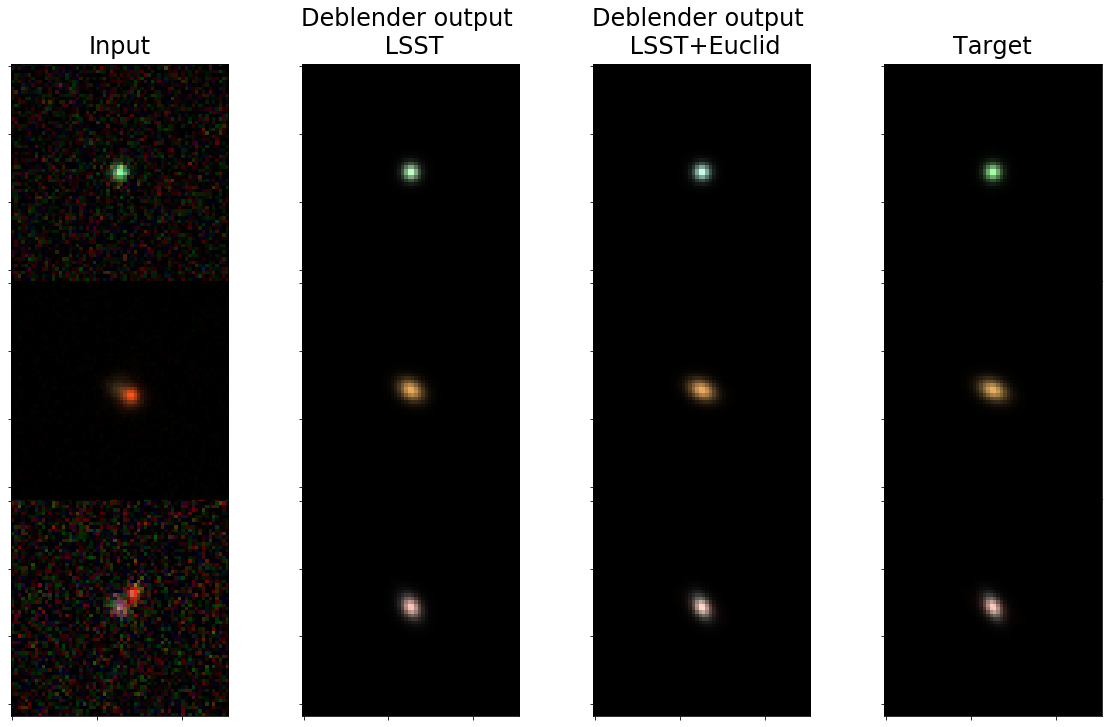

In [35]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.subplots_adjust(hspace=0)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))



####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Input', pad = 10)

ax = axes[0,1]
plot_rgb_lsst(np.mean(output_deblender[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST', pad = 10)

ax = axes[0,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST+Euclid', pad = 10)

ax = axes[0,3]
plot_rgb_lsst_euclid(input_noiseless[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Target', pad = 10)


####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
plot_rgb_lsst(np.mean(output_deblender[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,3]
plot_rgb_lsst_euclid(input_noiseless[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
plot_rgb_lsst(np.mean(output_deblender[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,3]
plot_rgb_lsst_euclid(input_noiseless[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

In [36]:
blend_rate

[array([], dtype=float64),
 array([0.53614187, 0.27017361, 0.28062558]),
 array([0.10091618])]

0.16652507 0.3


Text(0.5, 0, 'total flux in - total flux out / \n total flux in')

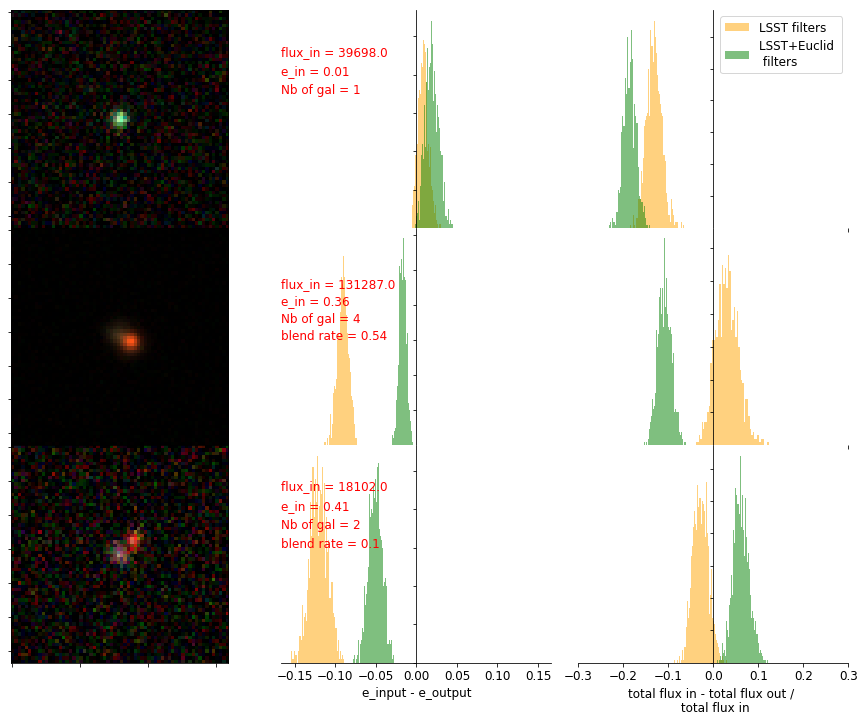

In [37]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))

max_x = np.max(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
min_x = np.min(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
max_lim_flux = 0.3# np.max((np.abs(max_x), np.abs(min_x)))

print(max_lim, max_lim_flux)
####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('Input', pad = 10)

ax = axes[0,1]
ax.hist(res_out_lsst_e[0]- res_in_e[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[0]- res_in_e[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[0], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[0])+1, 0)), fontsize =12, color='r')
if len(blend_rate[0])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[0]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)

ax = axes[0,2]
ax.hist((flux_out_lsst[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.legend()
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)



####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
ax.hist(res_out_lsst_e[1]- res_in_e[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[1]- res_in_e[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color ='green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[1], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[1])+1, 0)), fontsize =12, color='r')
if len(blend_rate[1])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[1]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
ax.hist((flux_out_lsst[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
ax.hist(res_out_lsst_e[2]-res_in_e[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[2]- res_in_e[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[2], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[2])+1, 0)), fontsize =12, color='r')
if len(blend_rate[2])!=0:
       ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[2]), 2)), fontsize =12, color='r')

ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('e_input - e_output')


ax = axes[2,2]
ax.hist((flux_out_lsst[2]-flux_in[2])/flux_in[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[2]- flux_in[2])/flux_in[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('total flux in - total flux out / \n total flux in')
